In [1]:
# Importation des bibliothèques nécessaires
import numpy as np
import pandas as pd
import os
import gc
import re
import time
import json
import mlflow
import mlflow.sklearn
from mlflow.tracking import MlflowClient
from mlflow.models.signature import infer_signature
import matplotlib.pyplot as plt
import seaborn as sns
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from xgboost import callback
from lightgbm import early_stopping, log_evaluation
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, roc_curve, confusion_matrix, make_scorer
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope
import shap
from IPython.display import display, FileLink, HTML
import warnings
import joblib
import subprocess

C:\Users\guigo\anaconda3\envs\projet-scoring\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

Démarrage d'une session de suivi MLFlow

In [3]:
mlflow.set_tracking_uri("file:///C:/Users/guigo/Documents/FORMATION/Alternance/Projet 7/mlruns")
experiment = mlflow.set_experiment("P7_Scoring")

print(f"Expérience actuelle : {experiment.name} (ID: {experiment.experiment_id})")
print(f"Les runs seront stockés ici : {mlflow.get_tracking_uri()}")

2025/04/24 20:40:56 INFO mlflow.tracking.fluent: Experiment with name 'P7_Scoring' does not exist. Creating a new experiment.


Expérience actuelle : P7_Scoring (ID: 719211569620934913)
Les runs seront stockés ici : file:///C:/Users/guigo/Documents/FORMATION/Alternance/Projet 7/mlruns


# 1.Définition des fonctions

In [4]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# Fonction pour calculer les valeurs manquantes
def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(columns={0: 'Valeurs manquantes', 1: '% du total'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:, 1] != 0] \
        .sort_values('% du total', ascending=False).round(1)
    print(f"Le dataframe contient {df.shape[1]} colonnes.\n"
          f"Il y a {mis_val_table_ren_columns.shape[0]} colonnes qui ont des valeurs manquantes.")
    return mis_val_table_ren_columns

# Fonction d'analyse exploratoire pour une table
def analyze_table(df, table_name):
    print(f"\n=== Analyse pour {table_name} ===")
    print(f"Taille : {df.shape}")
    print("Aperçu des premières lignes :")
    display(df.head())
    print("\n--- Distribution des types de colonnes :")
    print(df.dtypes.value_counts())
    print("\n--- Valeurs manquantes :")
    missing_values = missing_values_table(df)
    print(missing_values.head(10))

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category=True):
    original_columns = list(df.columns)
    # Sélection des colonnes catégorielles
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    # Forcer la conversion en chaîne pour être sûr que get_dummies fonctionne bien
    for col in categorical_columns:
        df[col] = df[col].astype(str)
    # Appliquer get_dummies
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns


# Fonction pour créer des features polynomiales
def create_polynomial_features(df_train, df_test, features):
    # Création des datasets pour les features polynomiales
    poly_train = df_train[features]
    poly_test = df_test[features]

    # Imputation des valeurs manquantes
    imputer = SimpleImputer(strategy='median')
    poly_train = imputer.fit_transform(poly_train)
    poly_test = imputer.transform(poly_test)

    # Génération des features polynomiales (degree=2)
    poly_transformer = PolynomialFeatures(degree=2)
    poly_train = poly_transformer.fit_transform(poly_train)
    poly_test = poly_transformer.transform(poly_test)

    # Récupération des noms des nouvelles features
    feature_names = poly_transformer.get_feature_names_out(features)

    # Conversion en DataFrame
    poly_train = pd.DataFrame(poly_train, columns=feature_names)
    poly_test = pd.DataFrame(poly_test, columns=feature_names)

    # Ajout de l'identifiant SK_ID_CURR pour fusion avec les datasets principaux
    poly_train['SK_ID_CURR'] = df_train['SK_ID_CURR']
    poly_test['SK_ID_CURR'] = df_test['SK_ID_CURR']

    return poly_train, poly_test


# Fonction pour afficher l'importance des features
def display_importances(feature_importance_df_):
    cols = (
        feature_importance_df_[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:40]
        .index
    )
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(
        x="importance",
        y="feature",
        data=best_features.sort_values(by="importance", ascending=False),
    )
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')

# Fonction pour calculer l'indice d'information mutuelle
def calculate_mutual_information(df, target_col, n_top_features=80):
    """
    Calcule l'indice d'information mutuelle entre chaque colonne d'un DataFrame et une colonne cible.
    Retourne les colonnes les plus pertinentes.
    """
    # Identification des colonnes numériques
    num_cols = df.select_dtypes(include=['float64', 'int64', 'float32', 'int32']).columns
    num_cols = [col for col in num_cols if col != target_col]  # Exclure la cible

    # Calcul de l'information mutuelle
    mi_scores = mutual_info_classif(df[num_cols], df[target_col], discrete_features=False, random_state=42)

    # Création d'un DataFrame avec les scores
    mi_scores_df = pd.DataFrame({'Feature': num_cols, 'MI_Score': mi_scores})
    mi_scores_df = mi_scores_df.sort_values(by='MI_Score', ascending=False).reset_index(drop=True)

    print(f"Top {n_top_features} features basées sur l'information mutuelle :")
    print(mi_scores_df.head(n_top_features))

    # Retour des n meilleures features
    return mi_scores_df['Feature'].head(n_top_features).tolist()

def reduce_mem_usage(df):
    """Réduit l'utilisation mémoire du DataFrame en changeant les types numériques."""
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min >= np.iinfo(np.int8).min and c_max <= np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
            else:
                df[col] = df[col].astype(np.float32)
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    return df

def kfold_xgboost(df, num_folds=3, stratified=False, debug=False):
    """
    Entraîne un modèle XGBoost avec validation croisée (KFold ou StratifiedKFold)
    et retourne un DataFrame contenant l'importance des features.

    Arguments :
        df : DataFrame contenant les données d'entraînement et de test.
        num_folds : Nombre de folds pour la validation croisée.
        stratified : Si True, utilise StratifiedKFold.
        debug : Si True, n'enregistre pas le fichier de soumission.

    Retourne :
        feature_importance_df : DataFrame avec l'importance des features.
    """
    # Séparation des données d'entraînement et de test
    train_df = df[df['TARGET'].notnull()].copy()
    test_df = df[df['TARGET'].isnull()].copy()
    print(f"Starting XGBoost. Train shape: {train_df.shape}, test shape: {test_df.shape}")

    # Libération de la mémoire
    del df
    gc.collect()

    # Nettoyage des valeurs infinies : remplace np.inf et -np.inf par np.nan
    train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    test_df.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Choix de la méthode de validation croisée
    if stratified:
        folds = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits=num_folds, shuffle=True, random_state=1001)

    # Initialisation des tableaux pour les prédictions et l'importance
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()

    # Liste des features à utiliser (excluant TARGET et les identifiants)
    feats = [f for f in train_df.columns if f not in ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index']]

    # Nettoyage des noms de colonnes (remplace les caractères spéciaux par '_')
    train_df = train_df.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '_', x))
    test_df = test_df.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '_', x))
    feats = [re.sub('[^A-Za-z0-9_]+', '_', f) for f in feats]

    # Boucle sur les folds de validation croisée
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # Initialisation du classifieur XGBoost avec support GPU (CUDA)
        clf = XGBClassifier(
            n_estimators=10000,
            learning_rate=0.02,
            max_depth=6,
            reg_alpha=0.02,
            reg_lambda=0.04,
            colsample_bytree=0.8,
            subsample=0.8,
            tree_method='hist',  
            predictor='cpu_predictor',  
            n_jobs=-1,  # Utiliser tous les cœurs du processeur
            use_label_encoder=False,
            eval_metric='auc',
            verbosity=0,
            early_stopping_rounds=100      
        )

        # Entraînement du modèle avec early stopping
        clf.fit(
            train_x, train_y,
            eval_set=[(valid_x, valid_y)],
            verbose=True
        )

        # Prédictions sur le set de validation et sur le set de test
        oof_preds[valid_idx] = clf.predict_proba(valid_x)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats])[:, 1] / folds.n_splits

        # Extraction de l'importance des features pour ce fold
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

        print(f'Fold {n_fold + 1} AUC : {roc_auc_score(valid_y, oof_preds[valid_idx]):.6f}')

        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    # Score global AUC sur le set d'entraînement
    print(f'Full AUC score {roc_auc_score(train_df["TARGET"], oof_preds):.6f}')

    # Génération du fichier de soumission si nécessaire
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv('submission.csv', index=False)

    # Affichage de l'importance des features 
    display_importances(feature_importance_df)

    return feature_importance_df

def select_features_with_sampling(df, target_col='TARGET', n_features=40, sample_size=50000):
    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestClassifier
    import pandas as pd

    # Suppression des lignes où TARGET est NaN
    df = df.dropna(subset=[target_col])  

    # S'assurer que sample_size n'est pas plus grand que la taille du DataFrame
    sample_size = min(sample_size, len(df))

    # Échantillonnage stratifié pour préserver la distribution de TARGET
    df_sample, _ = train_test_split(
        df, 
        train_size=sample_size, 
        stratify=df[target_col], 
        random_state=42
    )

    print(f"Utilisation d'un échantillon de {len(df_sample)} lignes pour la sélection des features")

    X = df_sample.drop(['TARGET', 'SK_ID_CURR'], axis=1)
    y = df_sample[target_col]

    # Remplacement des valeurs infinies par NaN
    X.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Remplacement des NaN par la médiane de chaque colonne
    X.fillna(X.median(), inplace=True)

    # Entraînement du modèle RandomForest
    model = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_leaf=10,
        n_jobs=-1,
        random_state=42
    )

    model.fit(X, y)

    # Création d'un DataFrame d'importance
    importance_df = pd.DataFrame({
        'feature': X.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)

    # Sélection des meilleures caractéristiques
    selected_features = importance_df.head(n_features)['feature'].tolist()

    return selected_features, importance_df

# 2.Chargement des données

In [5]:
# Chemin vers le dossier contenant les datasets
dataset_dir = r"C:\Users\guigo\Documents\FORMATION\Alternance\Projet 7\Données P7"

# Chargement des fichiers CSV en utilisant os.path.join pour gérer correctement les séparateurs
df_train = pd.read_csv(os.path.join(dataset_dir, "application_train.csv"))
df_test = pd.read_csv(os.path.join(dataset_dir, "application_test.csv"))
df_bureau = pd.read_csv(os.path.join(dataset_dir, "bureau.csv"))
df_bureau_balance = pd.read_csv(os.path.join(dataset_dir, "bureau_balance.csv"))
df_previous = pd.read_csv(os.path.join(dataset_dir, "previous_application.csv"))
df_credit_card = pd.read_csv(os.path.join(dataset_dir, "credit_card_balance.csv"))
df_pos_cash = pd.read_csv(os.path.join(dataset_dir, "POS_CASH_balance.csv"))
df_installments = pd.read_csv(os.path.join(dataset_dir, "installments_payments.csv"))
print("Fichiers chargés avec succès !")

Fichiers chargés avec succès !


# 3.Analyse exploratoire / Feature engineering

## Exploration des tables

J'affiche ici des informations essentielles sur les tables, telles que la taille, un aperçu des premières lignes, la distribution des types de données, ainsi que les détails des valeurs manquantes.

In [6]:
analyze_table(df_train, "application_train")
analyze_table(df_test, "application_test")
analyze_table(df_bureau, "bureau")
analyze_table(df_bureau_balance, "bureau_balance")
analyze_table(df_previous, "previous_application")
analyze_table(df_credit_card, "credit_card_balance")
analyze_table(df_pos_cash, "POS_CASH_balance")
analyze_table(df_installments, "installments_payments")


=== Analyse pour application_train ===
Taille : (307511, 122)
Aperçu des premières lignes :


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,


--- Distribution des types de colonnes :
float64    65
int64      41
object     16
Name: count, dtype: int64

--- Valeurs manquantes :
Le dataframe contient 122 colonnes.
Il y a 67 colonnes qui ont des valeurs manquantes.
                          Valeurs manquantes  % du total
COMMONAREA_MEDI                       214865        69.9
COMMONAREA_AVG                        214865        69.9
COMMONAREA_MODE                       214865        69.9
NONLIVINGAPARTMENTS_MEDI              213514        69.4
NONLIVINGAPARTMENTS_MODE              213514        69.4
NONLIVINGAPARTMENTS_AVG               213514        69.4
FONDKAPREMONT_MODE                    210295        68.4
LIVINGAPARTMENTS_MODE                 210199        68.4
LIVINGAPARTMENTS_MEDI                 210199        68.4
LIVINGAPARTMENTS_AVG                  210199        68.4

=== Analyse pour application_test ===
Taille : (48744, 121)
Aperçu des premières lignes :


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.752614,0.789654,0.159520,0.0660,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0505,NaN,NaN,0.0672,0.0612,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0526,NaN,NaN,0.0666,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0514,NaN,NaN,NaN,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469,-9118.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,0.564990,0.291656,0.432962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019101,-20038,-4458,-2175.0,-3503,5.0,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,NaN,0.699787,0.610991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secondary / secondary special,Married


--- Distribution des types de colonnes :
float64    65
int64      40
object     16
Name: count, dtype: int64

--- Valeurs manquantes :
Le dataframe contient 121 colonnes.
Il y a 64 colonnes qui ont des valeurs manquantes.
                          Valeurs manquantes  % du total
COMMONAREA_MODE                        33495        68.7
COMMONAREA_MEDI                        33495        68.7
COMMONAREA_AVG                         33495        68.7
NONLIVINGAPARTMENTS_MEDI               33347        68.4
NONLIVINGAPARTMENTS_AVG                33347        68.4
NONLIVINGAPARTMENTS_MODE               33347        68.4
FONDKAPREMONT_MODE                     32797        67.3
LIVINGAPARTMENTS_MODE                  32780        67.2
LIVINGAPARTMENTS_MEDI                  32780        67.2
LIVINGAPARTMENTS_AVG                   32780        67.2

=== Analyse pour bureau ===
Taille : (1716428, 17)
Aperçu des premières lignes :


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN



--- Distribution des types de colonnes :
float64    8
int64      6
object     3
Name: count, dtype: int64

--- Valeurs manquantes :
Le dataframe contient 17 colonnes.
Il y a 7 colonnes qui ont des valeurs manquantes.
                        Valeurs manquantes  % du total
AMT_ANNUITY                        1226791        71.5
AMT_CREDIT_MAX_OVERDUE             1124488        65.5
DAYS_ENDDATE_FACT                   633653        36.9
AMT_CREDIT_SUM_LIMIT                591780        34.5
AMT_CREDIT_SUM_DEBT                 257669        15.0
DAYS_CREDIT_ENDDATE                 105553         6.1
AMT_CREDIT_SUM                          13         0.0

=== Analyse pour bureau_balance ===
Taille : (27299925, 3)
Aperçu des premières lignes :


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C



--- Distribution des types de colonnes :
int64     2
object    1
Name: count, dtype: int64

--- Valeurs manquantes :
Le dataframe contient 3 colonnes.
Il y a 0 colonnes qui ont des valeurs manquantes.
Empty DataFrame
Columns: [Valeurs manquantes, % du total]
Index: []

=== Analyse pour previous_application ===
Taille : (1670214, 37)
Aperçu des premières lignes :


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN



--- Distribution des types de colonnes :
object     16
float64    15
int64       6
Name: count, dtype: int64

--- Valeurs manquantes :
Le dataframe contient 37 colonnes.
Il y a 16 colonnes qui ont des valeurs manquantes.
                           Valeurs manquantes  % du total
RATE_INTEREST_PRIMARY                 1664263        99.6
RATE_INTEREST_PRIVILEGED              1664263        99.6
AMT_DOWN_PAYMENT                       895844        53.6
RATE_DOWN_PAYMENT                      895844        53.6
NAME_TYPE_SUITE                        820405        49.1
DAYS_FIRST_DRAWING                     673065        40.3
DAYS_FIRST_DUE                         673065        40.3
DAYS_LAST_DUE_1ST_VERSION              673065        40.3
DAYS_LAST_DUE                          673065        40.3
DAYS_TERMINATION                       673065        40.3

=== Analyse pour credit_card_balance ===
Taille : (3840312, 23)
Aperçu des premières lignes :


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,1800.0,1800.0,0.000,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,2250.0,2250.0,60175.080,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,2250.0,2250.0,26926.425,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,11925.0,11925.0,224949.285,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,27000.0,27000.0,443044.395,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0



--- Distribution des types de colonnes :
float64    15
int64       7
object      1
Name: count, dtype: int64

--- Valeurs manquantes :
Le dataframe contient 23 colonnes.
Il y a 9 colonnes qui ont des valeurs manquantes.
                            Valeurs manquantes  % du total
AMT_PAYMENT_CURRENT                     767988        20.0
AMT_DRAWINGS_ATM_CURRENT                749816        19.5
AMT_DRAWINGS_OTHER_CURRENT              749816        19.5
AMT_DRAWINGS_POS_CURRENT                749816        19.5
CNT_DRAWINGS_ATM_CURRENT                749816        19.5
CNT_DRAWINGS_OTHER_CURRENT              749816        19.5
CNT_DRAWINGS_POS_CURRENT                749816        19.5
AMT_INST_MIN_REGULARITY                 305236         7.9
CNT_INSTALMENT_MATURE_CUM               305236         7.9

=== Analyse pour POS_CASH_balance ===
Taille : (10001358, 8)
Aperçu des premières lignes :


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0



--- Distribution des types de colonnes :
int64      5
float64    2
object     1
Name: count, dtype: int64

--- Valeurs manquantes :
Le dataframe contient 8 colonnes.
Il y a 2 colonnes qui ont des valeurs manquantes.
                       Valeurs manquantes  % du total
CNT_INSTALMENT_FUTURE               26087         0.3
CNT_INSTALMENT                      26071         0.3

=== Analyse pour installments_payments ===
Taille : (13605401, 8)
Aperçu des premières lignes :


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585



--- Distribution des types de colonnes :
float64    5
int64      3
Name: count, dtype: int64

--- Valeurs manquantes :
Le dataframe contient 8 colonnes.
Il y a 2 colonnes qui ont des valeurs manquantes.
                    Valeurs manquantes  % du total
DAYS_ENTRY_PAYMENT                2905         0.0
AMT_PAYMENT                       2905         0.0


La variable TARGET dans df_train est la variable que nous souhaitons prédire.

Je vais utiliser la fonction 'reduce_memory_usage' pour optimiser l'utilisation de la mémoire en convertissant les colonnes de mon dataset en types de données plus économes, ce qui permettra de manipuler des datasets volumineux sans dépasser les limites de la RAM et d'améliorer les performances globales.

In [7]:
# Appliquer la réduction de mémoire sur tous les datasets
df_train = reduce_mem_usage(df_train)
df_test = reduce_mem_usage(df_test)
df_bureau = reduce_mem_usage(df_bureau)
df_bureau_balance = reduce_mem_usage(df_bureau_balance)
df_previous = reduce_mem_usage(df_previous)
df_credit_card = reduce_mem_usage(df_credit_card)
df_pos_cash = reduce_mem_usage(df_pos_cash)
df_installments = reduce_mem_usage(df_installments)

Memory usage of dataframe is 286.23 MB
Memory usage after optimization is: 128.16 MB
Memory usage of dataframe is 45.00 MB
Memory usage after optimization is: 20.27 MB
Memory usage of dataframe is 222.62 MB
Memory usage after optimization is: 119.49 MB
Memory usage of dataframe is 624.85 MB
Memory usage after optimization is: 338.46 MB
Memory usage of dataframe is 471.48 MB
Memory usage after optimization is: 324.94 MB
Memory usage of dataframe is 673.88 MB
Memory usage after optimization is: 318.63 MB
Memory usage of dataframe is 610.43 MB
Memory usage after optimization is: 276.60 MB
Memory usage of dataframe is 830.41 MB
Memory usage after optimization is: 389.25 MB


## a.Tables Train et Test

### Gestion des variables catégorielles

Nous avons 2 possibilités pour l'encodage des variables catégorielles : l'encodage par etiquette (Label Encoding) ou l'encodage One-Hot. L'encodage par étiquette a l'avantage de ne pas crée de nouvelles colonnes mais il donne un ordre arbitraire aux catégories, qui peut être interprété de manière significatif par le modèle.  
Nous utiliserons donc le Label Encoding pour les variables avec 2 catégories, et le One-Hot Encoding pour les autres variables

**Label Enconder**

In [8]:
# Définition du LabelEncoder
le = LabelEncoder()
le_count = 0

# Itération sur chaque colonne concernée
for col in df_train:
    if df_train[col].dtype == 'object':
        # Si 2 catégories ou moins
        if len(list(df_train[col].unique())) <= 2:
            # Train sur le dataset d'entrainement
            le.fit(df_train[col])
            # Transformation du dataset d'entrainement et de test
            df_train[col] = le.transform(df_train[col])
            df_test[col] = le.transform(df_test[col])

            le_count += 1

print('%d colonnes ont été encodées.' % le_count)

3 colonnes ont été encodées.


**One-Hot Encoder**

In [9]:
# one-hot encoding pour les variables categorielles
df_train = pd.get_dummies(df_train)
df_test = pd.get_dummies(df_test)

print('Taille de df_train: ', df_train.shape)
print('Taille de df_test: ', df_test.shape)

Taille de df_train:  (307511, 243)
Taille de df_test:  (48744, 239)


Nous constatons que l'encodage One-Hot a créé plus de colonnes dans les données d'entraînement, car certaines variables catégoriques possédaient des catégories qui ne sont pas représentées dans les données de test.  
Il faut donc aligner les dataframes et supprimer les colonnes présentes dans les données d'entraînement mais absentes dans les données de test.

In [10]:
# Récupération des étiquettes (labels) cibles du dataframe d'entraînement
train_labels = df_train['TARGET']

# Alignement des données d'entraînement et de test, en ne gardant que les colonnes communes aux deux dataframes
df_train, df_test = df_train.align(df_test, join='inner', axis=1)

# Réintégraion de la colonne 'TARGET' dans le dataframe d'entraînement
df_train['TARGET'] = train_labels

# Affichage des dimensions des données d'entraînement et de test après alignement
print('Dimensions des caractéristiques d\'entraînement : ', df_train.shape)
print('Dimensions des caractéristiques de test : ', df_test.shape)

Dimensions des caractéristiques d'entraînement :  (307511, 240)
Dimensions des caractéristiques de test :  (48744, 239)


### Variable 'TARGET'


=== Distribution de TARGET ===
TARGET
0    282686
1     24825
Name: count, dtype: int64


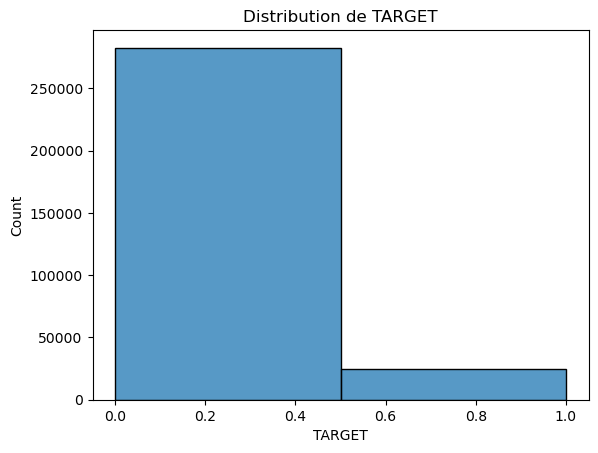

In [11]:
print("\n=== Distribution de TARGET ===")
print(df_train['TARGET'].value_counts())
sns.histplot(df_train['TARGET'], bins=2)
plt.title("Distribution de TARGET")
plt.show()

Nous constatons un fort déséquilibre entre les 2 valeurs de Target. La valeur 0(prêt a été remboursé) est sur-représentée par rapport à la valeur 1 (prêt en défaut)
Je proposerai une méthode de reéquilibrage des données un peu plus tard

### Recherche d'anomalies dans les Train et Test

Lors de l'analyse exploratoire des tables, j'ai noté des valeurs négatives pour 'DAYS_BIRTH' et 'DAYS-EMPLOYED' qui m'empêche de lire correctement cette donnée

<Axes: ylabel='Frequency'>

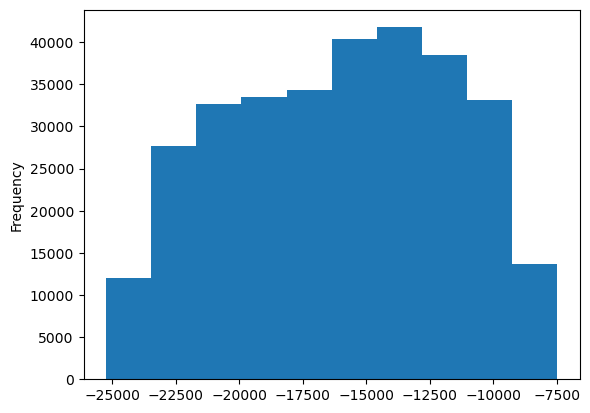

In [12]:
#Analyse de la variable DAYS_BIRTH
df_train['DAYS_BIRTH'].plot.hist()

Les valeurs de la colonne DAYS_BIRTH sont négatives parce qu'elles sont enregistrées par rapport à la date de la demande de prêt. Pour pouvoir observer ces données en années, nous allons multiplier par -1 et diviser par le nombre de jours dans une année

In [13]:
(df_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

Ces données semblent cohérentes

In [14]:
#Analyse de la variable DAYS_EMPLOYED
df_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

Le max corespond à environ 1000 ans, ce qui n'est pas réaliste pour une ancienneté dans un emploi.  
Afin de savoir comment traiter cette anomalie, nous allons regarder les valeurs de notre cible pour ces données

In [15]:
anom = df_train[df_train['DAYS_EMPLOYED'] == 365243]
non_anom = df_train[df_train['DAYS_EMPLOYED'] != 365243]
print('Les non-anomalies font défaut sur  %0.2f%% des prêts ' % (100 * non_anom['TARGET'].mean()))
print('Les anomalies font défaut sur %0.2f%% des prêts' % (100 * anom['TARGET'].mean()))
print('Il y a %d ligne avec des DAYS_EMPLOYED anormaux' % len(anom))

Les non-anomalies font défaut sur  8.66% des prêts 
Les anomalies font défaut sur 5.40% des prêts
Il y a 55374 ligne avec des DAYS_EMPLOYED anormaux


Les anomalies ont un taux de défaut plus faible. Elles partagent peut être des caractéristique communes.  
Je vais les remplacer par Nan et creer une nouvelle colonne booléenne indiquant si elle correspondait à une anomalie ou non afin d'informer le modèle d'apprentissage

### Traitement des valeurs manquantes

Traitement des valeurs manquantes et anomalies pour 'DAYS_EMPLOYED' dans df_train et df_test

In [16]:
## Identification des anomalies dans DAYS_EMPLOYED
df_train['DAYS_EMPLOYED_ANOM'] = df_train["DAYS_EMPLOYED"] == 365243
df_test['DAYS_EMPLOYED_ANOM'] = df_test["DAYS_EMPLOYED"] == 365243

## Remplacement de la valeur aberrante par NaN
df_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace=True)
df_test['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace=True)

Pour les autres colonnes :

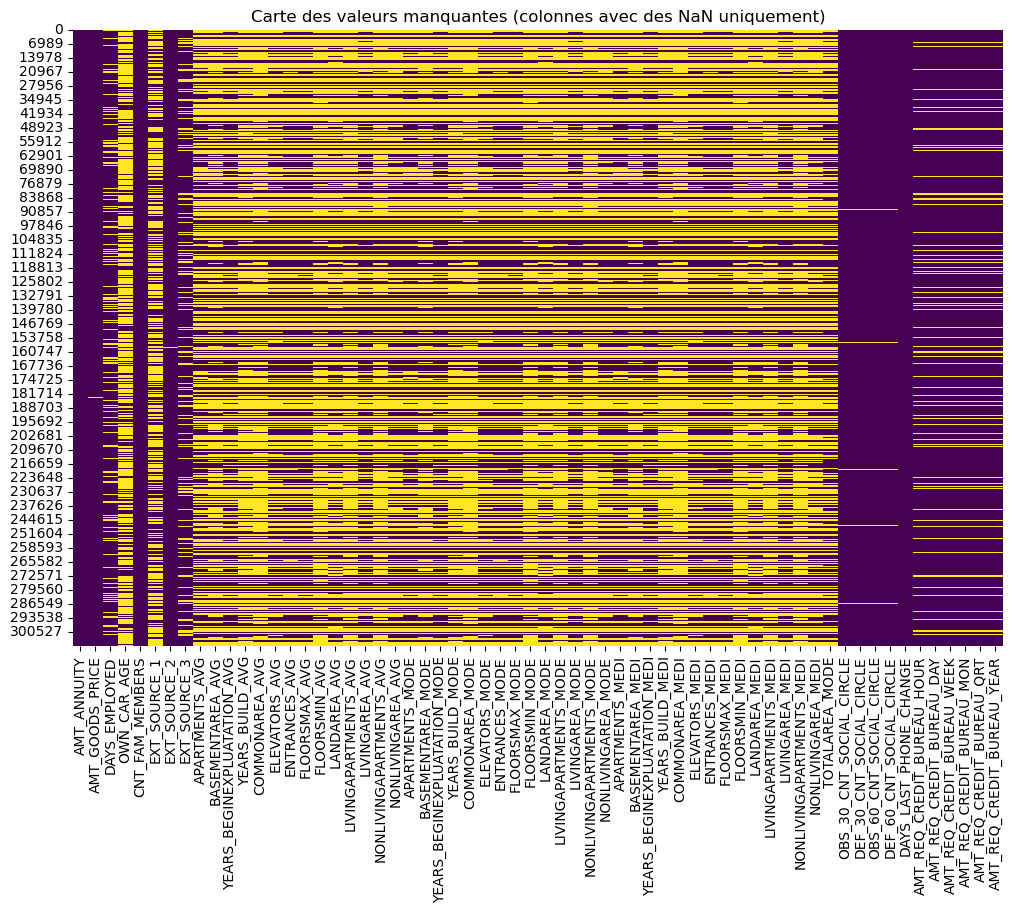

In [17]:
# Ne garder que les colonnes ayant des valeurs manquantes
cols_with_na = df_train.columns[df_train.isnull().any()]

# Heatmap des valeurs manquantes uniquement pour ces colonnes
plt.figure(figsize=(12, 8))
sns.heatmap(df_train[cols_with_na].isnull(), cbar=False, cmap="viridis")
plt.title("Carte des valeurs manquantes (colonnes avec des NaN uniquement)")
plt.show()

In [18]:
# Liste des colonnes pour l'imputation (toutes les colonnes sauf TARGET pour df_train)
features = [col for col in df_train.columns if col not in ['TARGET']]

# Imputation des valeurs manquantes
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')

# Ajustement de l'imputer sur df_train
imputer.fit(df_train[features])

# Application de l'imputer sur df_train et df_test
df_train[features] = imputer.transform(df_train[features])
df_test[features] = imputer.transform(df_test[features])

### Correlation

In [19]:
# Recherche de correlations avec la variable cible TARGET
correlations = df_train.corr()['TARGET'].sort_values()

# Affichage
print('Plus grandes correlations positives:\n', correlations.tail(15))
print('\nPlus petites correlations positives:\n', correlations.head(15))

Plus grandes correlations positives:
 OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_EMPLOYED                                        0.063368
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64

Pl

<Axes: xlabel='TARGET', ylabel='DAYS_BIRTH'>

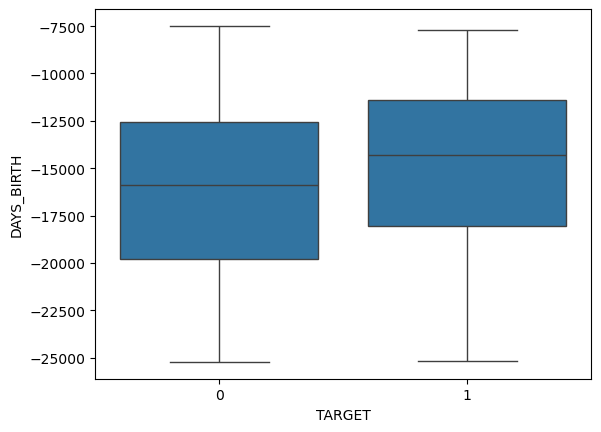

In [20]:
sns.boxplot(x='TARGET', y='DAYS_BIRTH', data=df_train)

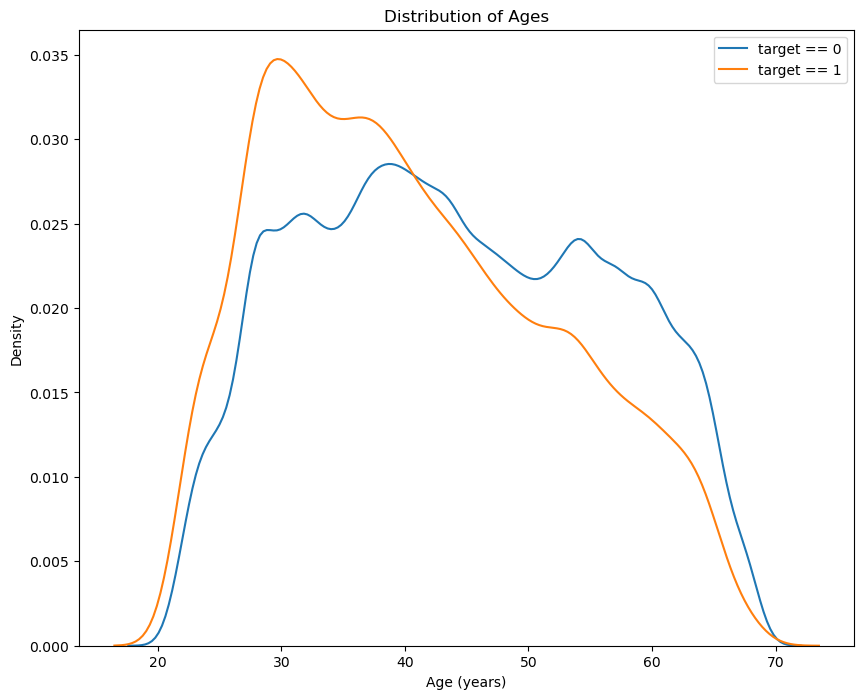

In [21]:
plt.figure(figsize = (10, 8))

# KDE des prêts remboursé à temps
sns.kdeplot(df_train.loc[df_train['TARGET'] == 0, 'DAYS_BIRTH'] / -365, label = 'target == 0')

# KDE des prêts non remboursé à temps
sns.kdeplot(df_train.loc[df_train['TARGET'] == 1, 'DAYS_BIRTH'] / -365, label = 'target == 1')

# Afichage du graphique
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages'); plt.legend()

Nous constatons que les clients plus âgés ont un risque de défaut plus faible.

Les trois variables ayant les corrélations négatives les plus fortes avec la cible sont EXT_SOURCE_1, EXT_SOURCE_2, et EXT_SOURCE_3. Selon la documentation, ces variables représentent un "score normalisé provenant d'une source de données externe"

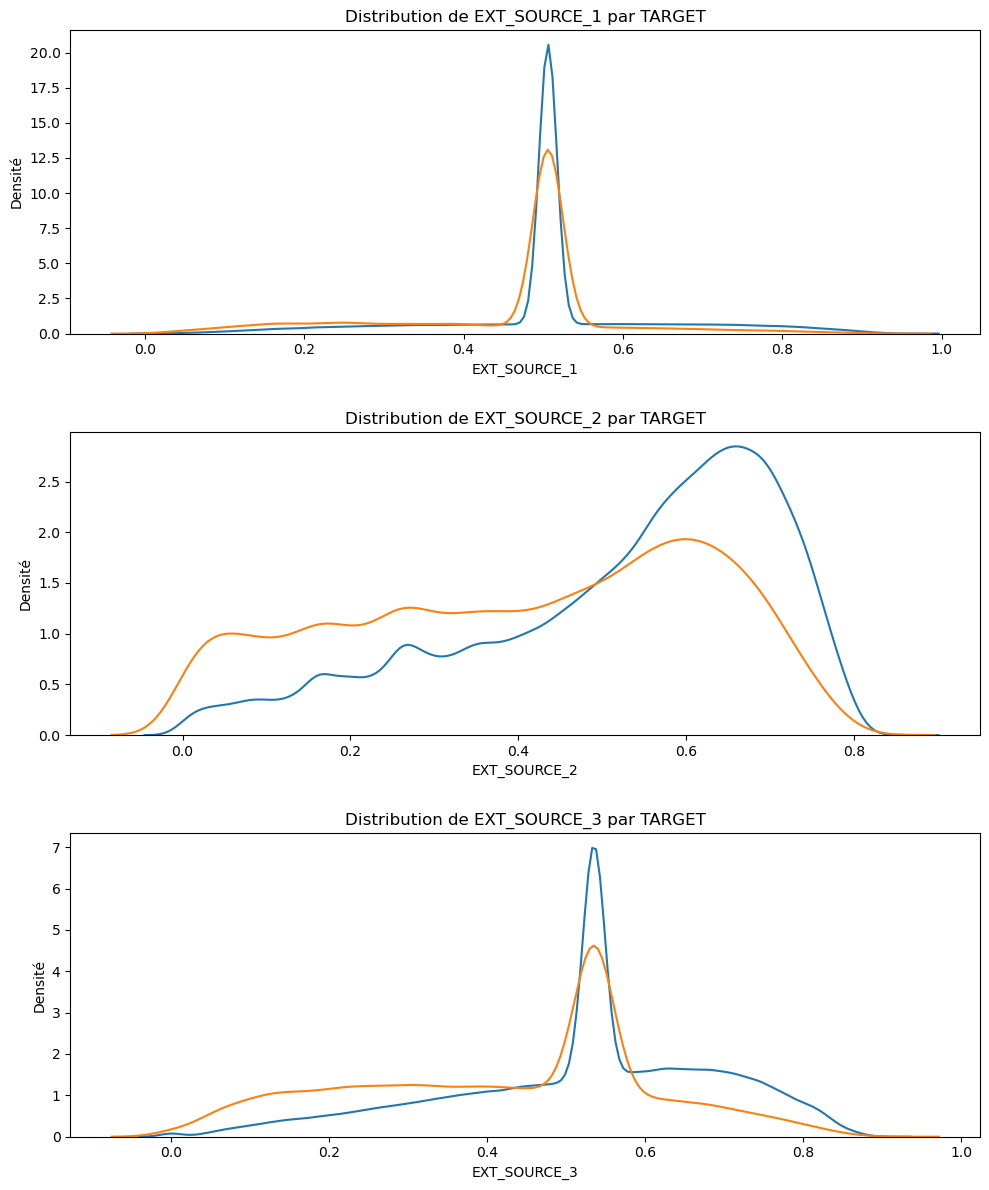

In [22]:
plt.figure(figsize = (10, 12))

# Iteration sur les variables concernées
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):

    # creation d'un subplot pour chaque variable
    plt.subplot(3, 1, i + 1)
    # Courbe de densité pour les clients ayant remboursé leur crédit (TARGET = 0)
    sns.kdeplot(df_train.loc[df_train['TARGET'] == 0, source], label = 'target == 0')
    # Courbe de densité pour les clients en défaut de paiement (TARGET = 1)
    sns.kdeplot(df_train.loc[df_train['TARGET'] == 1, source], label = 'target == 1')

    # Titre et axes du graphique
    plt.title('Distribution de %s par TARGET' % source)
    plt.xlabel('%s' % source); plt.ylabel('Densité');

plt.tight_layout(h_pad = 2.5)

Les graphiques de Distribution de EXT_SOURCE_2 et EXT_SOURCE_3  montre une différence notable entre les deux distributions (bleue et orange), indiquant que EXT_SOURCE_2 et EXT_SOURCE_3  ont une certaine capacité à distinguer les clients qui remboursent leurs prêts de ceux qui ne les remboursent pas.

### Création de nouvelles features

**Features métier**

Ces features sont inspirées du script https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features?scriptVersionId=6025993

*   CREDIT_INCOME_PERCENT : le pourcentage du montant du crédit par rapport aux revenus du client.
*   ANNUITY_INCOME_PERCENT : le pourcentage de l'annuité du prêt par rapport aux revenus du client.
*   CREDIT_TERM : la durée de remboursement en mois (puisque l'annuité représente le montant dû chaque mois).
*   DAYS_EMPLOYED_PERCENT : le pourcentage des jours travaillés par rapport à l'âge du client.

In [23]:
df_train['CREDIT_INCOME_PERCENT'] = df_train['AMT_CREDIT'] / df_train['AMT_INCOME_TOTAL']
df_train['ANNUITY_INCOME_PERCENT'] = df_train['AMT_ANNUITY'] / df_train['AMT_INCOME_TOTAL']
df_train['CREDIT_TERM'] = df_train['AMT_ANNUITY'] / df_train['AMT_CREDIT']
df_train['DAYS_EMPLOYED_PERCENT'] = df_train['DAYS_EMPLOYED'] / df_train['DAYS_BIRTH']

In [24]:
df_test['CREDIT_INCOME_PERCENT'] = df_test['AMT_CREDIT'] / df_test['AMT_INCOME_TOTAL']
df_test['ANNUITY_INCOME_PERCENT'] = df_test['AMT_ANNUITY'] / df_test['AMT_INCOME_TOTAL']
df_test['CREDIT_TERM'] = df_test['AMT_ANNUITY'] / df_test['AMT_CREDIT']
df_test['DAYS_EMPLOYED_PERCENT'] = df_test['DAYS_EMPLOYED'] / df_test['DAYS_BIRTH']

**Features polynomiales**

In [25]:
# Création des features polynomiales
poly_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']
poly_train, poly_test = create_polynomial_features(df_train, df_test, poly_features)

In [26]:
# Fusion des features polynomiales avec les datasets principaux
df_train = pd.merge(df_train, poly_train, on='SK_ID_CURR', how='left')
df_test = pd.merge(df_test, poly_test, on='SK_ID_CURR', how='left')

### 1ere selection de features d'interet (80)

In [27]:
# Séparation des features et la cible
X = df_train.drop(columns=['TARGET', 'SK_ID_CURR'])
y = df_train['TARGET']

# Calcule de l'information mutuelle avec Scikit-learn
mutual_info = mutual_info_classif(X, y, random_state=42, discrete_features=False)

# Associaion des résultats aux colonnes
feature_scores = pd.Series(mutual_info, index=X.columns).sort_values(ascending=False)

# 80 meilleures features
top_features = feature_scores.head(80).index.tolist()
df_train = df_train[['SK_ID_CURR', 'TARGET'] + top_features]

In [28]:
top_features

['FLAG_MOBIL',
 '1',
 'FLAG_CONT_MOBILE',
 'NAME_EDUCATION_TYPE_Secondary / secondary special',
 'CODE_GENDER_F',
 'FLAG_EMP_PHONE',
 'FLAG_DOCUMENT_3',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE_Unaccompanied',
 'NAME_FAMILY_STATUS_Married',
 'NAME_HOUSING_TYPE_House / apartment',
 'FLOORSMIN_MODE',
 'FLOORSMIN_MEDI',
 'EMERGENCYSTATE_MODE_No',
 'FLOORSMIN_AVG',
 'NAME_INCOME_TYPE_Working',
 'HOUSETYPE_MODE_block of flats',
 'OWN_CAR_AGE',
 'REGION_RATING_CLIENT_W_CITY',
 'YEARS_BUILD_MEDI',
 'REGION_RATING_CLIENT',
 'LIVINGAPARTMENTS_MODE',
 'YEARS_BUILD_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAPARTMENTS_MEDI',
 'YEARS_BUILD_MODE',
 'FLOORSMAX_MODE',
 'FLOORSMAX_MEDI',
 'FLOORSMAX_AVG',
 'CNT_FAM_MEMBERS',
 'FLAG_OWN_CAR',
 'EXT_SOURCE_1_y',
 'CODE_GENDER_M',
 'EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_1_x',
 'BASEMENTAREA_MODE',
 'BASEMENTAREA_MEDI',
 'BASEMENTAREA_AVG',
 'EXT_SOURCE_1^2',
 'APARTMENTS_MODE',
 'CREDIT_TERM',
 'EXT_SOURCE_1 EXT_SOURCE_3',
 'ENTRANCES_MODE',
 'APARTMENTS_AVG

In [29]:
# Alignement de dt_train et df_test
## Garder uniquement les colonnes de df_train (hors TARGET) dans df_test
df_test = df_test[['SK_ID_CURR'] + top_features] 

# Vérification
print("Taille de df_train : ", df_train.shape)
print("Taille de df_test : ", df_test.shape)

Taille de df_train :  (307511, 82)
Taille de df_test :  (48744, 81)


In [30]:
# Enregistrement des fichiers df_train et df_test en format Parquet
df_train.to_parquet(os.path.join(dataset_dir, "df_train"), index=False)
df_test.to_parquet(os.path.join(dataset_dir, "df_test"), index=False)

print(f"Fichiers enregistrés avec succès dans le dossier : {dataset_dir}")

Fichiers enregistrés avec succès dans le dossier : C:\Users\guigo\Documents\FORMATION\Alternance\Projet 7\Données P7


## b.Tables bureau et bureau_balance

In [31]:
def bureau_and_balance(num_rows=None, nan_as_category=True):
    # Définition du dossier où se trouve le fichier CSV
    dossier = r"C:\Users\guigo\Documents\FORMATION\Alternance\Projet 7\Données P7"

    # Chargement du fichier CSV contenant les données
    bureau = pd.read_csv(os.path.join(dossier, "bureau.csv"), nrows=num_rows)

    # Réduction de l'utilisation de la mémoire pour optimiser le traitement
    bureau = reduce_mem_usage(bureau)

    bb = pd.read_csv(os.path.join(dossier, "bureau_balance.csv"), nrows=num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bb = reduce_mem_usage(bb)

    # Encodage one-hot des variables catégorielles si nécessaire
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)

    print("\n Colonnes après One-Hot Encoding :", bb.columns.tolist())

    # Définition des agrégations à appliquer sur les colonnes de bureau_balance
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}

    # Agrégation des colonnes dont le nom commence par "STATUS_"
    for col in bb.columns:
        if col.startswith("STATUS_"):
            bb_aggregations[col] = ['mean']

    print("\n Colonnes utilisées pour l'agrégation :", list(bb_aggregations.keys()))

    # Regroupement des données par 'SK_ID_BUREAU' et application des agrégations définies
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations).reset_index()

    print("\n Colonnes après agrégation :", bb_agg.columns.tolist())

     # Renommage des colonnes pour indiquer qu'elles proviennent de bureau_balance
    bb_agg.columns = ["CC_" + "_".join(map(str, col)).upper() if isinstance(col, tuple) else "CC_" + col for col in bb_agg.columns]

    # Vérification et correction des noms de colonnes pour 'SK_ID_BUREAU'
    if "CC_SK_ID_BUREAU" in bb_agg.columns:
        bb_agg.rename(columns={"CC_SK_ID_BUREAU": "SK_ID_BUREAU"}, inplace=True)
    if "CC_SK_ID_BUREAU_" in bb_agg.columns:
        bb_agg.rename(columns={"CC_SK_ID_BUREAU_": "SK_ID_BUREAU"}, inplace=True)

    print("\n Colonnes après renommage de SK_ID_BUREAU :", bb_agg.columns.tolist())

    # Fusion des données du fichier bureau avec celles de bureau_balance agrégé
    bureau = bureau.merge(bb_agg, on='SK_ID_BUREAU', how='left')

    # Suppression de la colonne 'SK_ID_BUREAU' qui n'est plus nécessaire après fusion
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace=True)

    # Libération de la mémoire en supprimant les objets inutilisés
    del bb, bb_agg
    gc.collect()

    # Définition des agrégations à appliquer sur les colonnes numériques de bureau
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],  # Statistiques sur les jours de crédit
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],  # Dates de fin de crédit
        'DAYS_CREDIT_UPDATE': ['mean'],  # Dernière mise à jour du crédit
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],  # Nombre de jours de retard
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],  # Montant maximum du crédit en retard
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],  # Somme des montants de crédit
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],  # Somme des dettes de crédit
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],  # Montant en retard de paiement
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],  # Limite de crédit
        'AMT_ANNUITY': ['max', 'mean'],  # Annuité des crédits
        'CNT_CREDIT_PROLONG': ['sum'],  # Nombre de fois où le crédit a été prolongé
        'CC_MONTHS_BALANCE_MIN': ['min'],  # Mois minimum du crédit
        'CC_MONTHS_BALANCE_MAX': ['max'],  # Mois maximum du crédit
        'CC_MONTHS_BALANCE_SIZE': ['mean', 'sum']  # Taille de l'historique du crédit
    }

    # Définition des agrégations pour les variables catégorielles
    cat_aggregations = {}

    # Ajout des variables catégorielles du fichier bureau
    for cat in bureau_cat:
        cat_aggregations[cat] = ['mean']
    for cat in bb_cat:
        if f"CC_{cat}_MEAN" in bureau.columns:
            cat_aggregations[f"CC_{cat}_MEAN"] = ['mean']

    # Agrégation des données finales par client 'SK_ID_CURR'
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations}).reset_index()

    print("\n Vérification de SK_ID_CURR après agrégation :", "SK_ID_CURR" in bureau_agg.columns)

    print("\n Colonnes après agrégation bureau :", bureau_agg.columns.tolist())

    # Renommage des colonnes pour indiquer qu'elles proviennent du fichier bureau
    bureau_agg.columns = [
        "BURO_" + "_".join(map(str, col)).upper() if isinstance(col, tuple) else "BURO_" + str(col)
        for col in bureau_agg.columns
    ]

    # Vérification et correction si 'SK_ID_CURR' est absent du dataset final
    if "SK_ID_CURR" not in bureau_agg.columns:
        bureau_agg.rename(columns={col: "SK_ID_CURR" for col in bureau_agg.columns if "SK_ID_CURR" in col}, inplace=True)

    # Suppression des '_'' en trop dans les noms de colonnes
    bureau_agg.columns = [col[:-1] if col.endswith("_") else col for col in bureau_agg.columns]

    print("\n Vérification finale de SK_ID_CURR :", "SK_ID_CURR" in bureau_agg.columns)
    print("\n Colonnes après renommage final :", bureau_agg.columns.tolist())

    # Retourne les données agrégées et transformées
    return bureau_agg

## c. Table previous application

In [32]:
def previous_applications(num_rows=None, nan_as_category=True):
    dossier = r"C:\Users\guigo\Documents\FORMATION\Alternance\Projet 7\Données P7"
    prev = pd.read_csv(os.path.join(dossier, "previous_application.csv"), nrows=num_rows)

    # Réduction de la mémoire
    prev = reduce_mem_usage(prev)

    # Encodage one-hot des variables catégorielles
    prev, cat_cols = one_hot_encoder(prev, nan_as_category=True)

    # Vérification des colonnes après One-Hot Encoding
    print("\n Colonnes après One-Hot Encoding :", prev.columns.tolist())

    # Remplacement des valeurs 365243 par NaN
    date_cols = ['DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION',
                 'DAYS_LAST_DUE', 'DAYS_TERMINATION']
    prev[date_cols] = prev[date_cols].replace(365243, np.nan)

    # Ajout de la variable : rapport entre montant demandé et crédit accordé
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']

    # Définition des agrégations numériques
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }

    # Définition des agrégations catégorielles
    cat_aggregations = {cat: ['mean'] for cat in cat_cols if cat in prev.columns}

    # Vérifier que les colonnes existent avant d'agréger
    valid_aggregations = {
        col: funcs for col, funcs in {**num_aggregations, **cat_aggregations}.items() if col in prev.columns
    }

    # Séparer les colonnes numériques et catégorielles
    num_cols = list(num_aggregations.keys())
    cat_cols = list(cat_aggregations.keys())

    # Agrégation seulement sur les colonnes existantes
    prev_agg = prev.groupby('SK_ID_CURR')[num_cols].agg(num_aggregations)

    # Correction du MultiIndex après aggregation
    prev_agg.columns = [
        "PREV_" + "_".join(map(str, col)).upper() if isinstance(col, tuple) else "PREV_" + col
        for col in prev_agg.columns
    ]
    prev_agg.reset_index(inplace=True)

    # Vérification après agrégation
    print("\n Colonnes après agrégation principale :", prev_agg.columns.tolist())

    # Agrégation spécifique : Applications approuvées
    if 'NAME_CONTRACT_STATUS_Approved' in prev.columns:
        approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1].copy()
        if not approved.empty:
            approved_agg = approved.groupby('SK_ID_CURR')[num_cols].agg(num_aggregations)
            approved_agg.columns = [
                "APPROVED_" + "_".join(map(str, col)).upper() if isinstance(col, tuple) else "APPROVED_" + col
                for col in approved_agg.columns
            ]
            approved_agg.reset_index(inplace=True)
            prev_agg = prev_agg.merge(approved_agg, on='SK_ID_CURR', how='left')

    # Agrégation spécifique : Applications refusées
    if 'NAME_CONTRACT_STATUS_Refused' in prev.columns:
        refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1].copy()
        if not refused.empty:
            refused_agg = refused.groupby('SK_ID_CURR')[num_cols].agg(num_aggregations)
            refused_agg.columns = [
                "REFUSED_" + "_".join(map(str, col)).upper() if isinstance(col, tuple) else "REFUSED_" + col
                for col in refused_agg.columns
            ]
            refused_agg.reset_index(inplace=True)
            prev_agg = prev_agg.merge(refused_agg, on='SK_ID_CURR', how='left')

    # Vérification finale de `SK_ID_CURR`
    print("\n Vérification finale de SK_ID_CURR :", "SK_ID_CURR" in prev_agg.columns)

    # Affichage des colonnes finales après agrégation et renommage
    print("\n Colonnes après renommage final :", prev_agg.columns.tolist())

    # Nettoyage mémoire
    del refused, approved, prev
    gc.collect()

    return prev_agg

## d.Table POSH_CASH_balance

In [33]:
# Prétraitement du fichier POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    dossier = r"C:\Users\guigo\Documents\FORMATION\Alternance\Projet 7\Données P7"
    pos = pd.read_csv(os.path.join(dossier, "POS_CASH_balance.csv"), nrows=num_rows)
    pos = reduce_mem_usage(pos)
    print("\nColonnes au chargement :", pos.columns.tolist())  # Vérifier les colonnes au début
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)

    # Définition des agrégations à appliquer sur les données
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }

    # Ajout des variables catégorielles encodées aux agrégations (calcul de la moyenne)
    for cat in cat_cols:
        aggregations[cat] = ['mean']

    # Agrégation des données par identifiant client `SK_ID_CURR`
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)

    # Renommage des colonnes pour préciser qu'elles proviennent des données POS CASH
    pos_agg.columns = ["POS_" + "_".join(map(str, e)).upper() if isinstance(e, tuple) else "POS_" + str(e) for e in pos_agg.columns]

    # Ajout d'une nouvelle colonne qui indique le nombre total de comptes POS CASH par client
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()

    # Suppression des données originales pour libérer de la mémoire
    del pos
    gc.collect()

    # Retourne le DataFrame agrégé
    return pos_agg

## e.Table Installments_payments

In [34]:
# Prétraitement du fichier installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    dossier = r"C:\Users\guigo\Documents\FORMATION\Alternance\Projet 7\Données P7"
    ins = pd.read_csv(os.path.join(dossier, "installments_payments.csv"), nrows=num_rows)
    
    ins = reduce_mem_usage(ins)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)

    # Calcul du pourcentage du montant payé par rapport au montant de l'échéance
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']

    # Calcul du retard de paiement (jours de dépassement)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)

    # Définition des agrégations pour regrouper les données par client (SK_ID_CURR)
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],  # Nombre unique de versions d'échéance
        'DPD': ['max', 'mean', 'sum'],  # Retard de paiement max, moyen et total
        'DBD': ['max', 'mean', 'sum'],  # Nombre de jours avant échéance max, moyen et total
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],  # Statistiques sur le pourcentage payé
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],  # Statistiques sur la différence de paiement
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],  # Montant de l'échéance max, moyen et total
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],  # Montant payé min, max, moyen et total
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']  # Jours d'entrée de paiement max, moyen et total
    }

     # Ajout des variables catégorielles encodées aux agrégations
    for cat in cat_cols:
        aggregations[cat] = ['mean']

    # Agrégation des données par client (SK_ID_CURR)
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)

    # Renommage des colonnes pour indiquer qu'il s'agit de données d'échéances
    ins_agg.columns = ["INSTAL_" + "_".join(map(str, e)).upper() if isinstance(e, tuple) else "INSTAL_" + str(e) for e in ins_agg.columns]

    # Comptage du nombre total d'échéances pour chaque client
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()

    # Libération de la mémoire en supprimant la variable ins
    del ins
    gc.collect()

    # Retourne le DataFrame agrégé
    return ins_agg

## f.Table credit_card_balance

In [35]:
# Prétraitement du fichier credit_card_balance.csv
def credit_card_balance(num_rows=None, nan_as_category=True):
    dossier = r"C:\Users\guigo\Documents\FORMATION\Alternance\Projet 7\Données P7"
    cc = pd.read_csv(os.path.join(dossier, "credit_card_balance.csv"), nrows=num_rows)
    cc = reduce_mem_usage(cc)                
    
    cc, cat_cols = one_hot_encoder(cc, nan_as_category=nan_as_category)

    # Définition des agrégations pour regrouper les données
    num_aggregations = {
        'MONTHS_BALANCE': ['min', 'max', 'mean', 'sum', 'var'],  # Historique des mois d'utilisation de la carte
        'AMT_BALANCE': ['min', 'max', 'mean', 'sum', 'var'],  # Solde du compte de carte de crédit
        'AMT_CREDIT_LIMIT_ACTUAL': ['min', 'max', 'mean', 'sum', 'var'],  # Limite de crédit actuelle
        'AMT_DRAWINGS_ATM_CURRENT': ['min', 'max', 'mean', 'sum', 'var'],  # Retraits effectués aux distributeurs
        'AMT_DRAWINGS_CURRENT': ['min', 'max', 'mean', 'sum', 'var'],  # Montant total des retraits
        'AMT_DRAWINGS_OTHER_CURRENT': ['min', 'max', 'mean', 'sum', 'var'],  # Retraits effectués hors distributeurs et points de vente
        'AMT_DRAWINGS_POS_CURRENT': ['min', 'max', 'mean', 'sum', 'var'],  # Montant des achats effectués en point de vente
        'AMT_INST_MIN_REGULARITY': ['min', 'max', 'mean', 'sum', 'var'],  # Montant minimum des paiements réguliers
        'AMT_PAYMENT_CURRENT': ['min', 'max', 'mean', 'sum', 'var'],  # Montant du dernier paiement
        'AMT_PAYMENT_TOTAL_CURRENT': ['min', 'max', 'mean', 'sum', 'var'],  # Montant total des paiements
        'AMT_RECEIVABLE_PRINCIPAL': ['min', 'max', 'mean', 'sum', 'var'],  # Capital restant dû
        'AMT_RECIVABLE': ['min', 'max', 'mean', 'sum', 'var'],  # Montant total recevable (possible duplication avec `AMT_TOTAL_RECEIVABLE`)
        'AMT_TOTAL_RECEIVABLE': ['min', 'max', 'mean', 'sum', 'var'],  # Montant total restant à recevoir
        'CNT_DRAWINGS_ATM_CURRENT': ['min', 'max', 'mean', 'sum', 'var'],  # Nombre de retraits aux distributeurs
        'CNT_DRAWINGS_CURRENT': ['min', 'max', 'mean', 'sum', 'var'],  # Nombre total de retraits effectués
        'CNT_DRAWINGS_OTHER_CURRENT': ['min', 'max', 'mean', 'sum', 'var'],  # Nombre de retraits hors ATM et point de vente
        'CNT_DRAWINGS_POS_CURRENT': ['min', 'max', 'mean', 'sum', 'var'],  # Nombre d'achats effectués en point de vente
        'CNT_INSTALMENT_MATURE_CUM': ['min', 'max', 'mean', 'sum', 'var'],  # Nombre cumulé d'échéances échues
        'SK_DPD': ['min', 'max', 'mean', 'sum', 'var'],  # Nombre de jours de retard
        'SK_DPD_DEF': ['min', 'max', 'mean', 'sum', 'var']  # Nombre de jours de défaut de paiement
    }

    # Définition des agrégations pour les variables catégorielles encodées
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']  # Moyenne pour les variables catégorielles encodées

    # Agrégation des données par client (`SK_ID_CURR`)
    cc_agg = cc.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})

    # Renommage des colonnes pour préciser qu'elles proviennent des données de carte de crédit
    cc_agg.columns = ["CC_" + "_".join(map(str, e)).upper() if isinstance(e, tuple) else "CC_" + str(e)
                      for e in cc_agg.columns]

    # Réinitialisation de l'index pour conserver `SK_ID_CURR` comme colonne classique
    cc_agg.reset_index(inplace=True)

    # Retourne le DataFrame agrégé
    return cc_agg

# 4.Création du dataframe final avant modélisation

In [36]:
# Chargement des fichiers df_train et df_test depuis le format Parquet
df_train = pd.read_parquet(os.path.join(dataset_dir, "df_train"))
df_test = pd.read_parquet(os.path.join(dataset_dir, "df_test"))

print("Fichiers chargés avec succès !")

Fichiers chargés avec succès !


In [37]:
def prepare_merged_data(debug=False):
    # Définition du nombre de lignes à traiter en mode debug (limite à 10 000 lignes si debug=True)
    num_rows = 10000 if debug else None

    # Vérification de la disponibilité des DataFrames df_train et df_test
    print("\n Vérification de df_train et df_test :", hasattr(df_train, "name"), hasattr(df_test, "name"))

    # Fusion des données d'entraînement (df_train) et de test (df_test)
    df = pd.concat([df_train, df_test], axis=0)

    # Traitement des données de bureau et bureau_balance
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows) # Chargement et agrégation des données bureau
        df = df.merge(bureau, on='SK_ID_CURR', how='left') # Fusion avec les données principales
        del bureau # Suppression de l'objet pour libérer la mémoire
        gc.collect() # Nettoyage de la mémoire

    # Traitement des demandes de crédit précédentes
    with timer("Process previous applications"):
        prev = previous_applications(num_rows)
        df = df.merge(prev, on='SK_ID_CURR', how='left')
        del prev
        gc.collect()

    # Traitement des données POS-CASH balance (crédits renouvelables)
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        df = df.merge(pos, on='SK_ID_CURR', how='left')
        del pos
        gc.collect()

    # Traitement des paiements d'acompte
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        df = df.merge(ins, on='SK_ID_CURR', how='left')
        del ins
        gc.collect()

    # Traitement des balances de carte de crédit
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        df = df.merge(cc, on='SK_ID_CURR', how='left')
        del cc
        gc.collect()

    # Réduction de la mémoire et sauvegarde du DataFrame final
    df = reduce_mem_usage(df)
    df.to_parquet("merged_df.parquet", index=False)
    file_path = "merged_df.parquet"
    display(FileLink(file_path))
    print("DataFrame fusionné sauvegardé en Parquet.")

    # Retourne le DataFrame fusionné
    return df

In [38]:
def prepare_train_test_split(df):
    """
    Sépare le DataFrame en ensemble d'entraînement et de test.

    Arguments :
    df : DataFrame contenant les données fusionnées.

    Retourne :
    - X_train : Features pour l'entraînement.
    - X_test : Features pour le test.
    - y_train : Cible pour l'entraînement.
    - y_test : Cible pour le test.
    """

    # Sélection des données d'entraînement en gardant uniquement les lignes où la variable TARGET est connue (non nulle)
    df_train_final = df[df['TARGET'].notnull()]

    # Séparation des features (X) et de la cible (y)
    X = df_train_final.drop(columns=['TARGET', 'SK_ID_CURR'])  # Enlever TARGET et ID client
    y = df_train_final['TARGET']  # Variable cible

    # Découpage des données en ensemble d'entraînement et de test (avec stratification)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    # Affichage des tailles des ensembles créés
    print("Taille de l'ensemble d'entraînement :", X_train.shape)
    print("Taille de l'ensemble de test :", X_test.shape)

    return X_train, X_test, y_train, y_test

In [39]:
if __name__ == "__main__":
    """
    Ce bloc de code est exécuté uniquement si le script est lancé directement.
    Il permet de préparer les données, entraîner un modèle RendomForest et extraire les caractéristiques les plus importantes.
    """

    # Préparation des données
    print("=== Étape 1 : Préparation des données ===")
    df = prepare_merged_data(debug=False)
    df = df.rename(columns=lambda c: re.sub('_+', '_', re.sub('[^A-Za-z0-9_]+', '_', c)))
    
    # Sélection rapide des caractéristiques
    print("\n=== Étape 2 : Sélection rapide des features ===")
    
    # Feature importance RandomForest
    selected_features, importance_df = select_features_with_sampling(
        df, 
        target_col='TARGET', 
        n_features=40, 
        sample_size=50000  
    )
    
    # Sauvegarde des importances
    importance_df.to_csv("feature_importance.csv", index=False)
    print("Importance des features sauvegardée dans 'feature_importance.csv'.")
    
    # Création du DataFrame réduit
    print("\n=== Étape 3 : Création du DataFrame réduit ===")
    reduced_df = df[selected_features + ['TARGET', 'SK_ID_CURR']]
    print(f"Le DataFrame réduit contient {reduced_df.shape[1]} colonnes.")
    print(reduced_df.head())
    
    # Préparation des ensembles train/test
    print("\n=== Étape 4 : Préparation des ensembles train/test ===")
    X_train, X_test, y_train, y_test = prepare_train_test_split(reduced_df)

=== Étape 1 : Préparation des données ===

 Vérification de df_train et df_test : False False
Memory usage of dataframe is 222.62 MB
Memory usage after optimization is: 119.49 MB
Memory usage of dataframe is 650.88 MB
Memory usage after optimization is: 1067.44 MB

 Colonnes après One-Hot Encoding : ['SK_ID_BUREAU', 'MONTHS_BALANCE', 'STATUS_0', 'STATUS_1', 'STATUS_2', 'STATUS_3', 'STATUS_4', 'STATUS_5', 'STATUS_C', 'STATUS_X', 'STATUS_nan']

 Colonnes utilisées pour l'agrégation : ['MONTHS_BALANCE', 'STATUS_0', 'STATUS_1', 'STATUS_2', 'STATUS_3', 'STATUS_4', 'STATUS_5', 'STATUS_C', 'STATUS_X', 'STATUS_nan']

 Colonnes après agrégation : [('SK_ID_BUREAU', ''), ('MONTHS_BALANCE', 'min'), ('MONTHS_BALANCE', 'max'), ('MONTHS_BALANCE', 'size'), ('STATUS_0', 'mean'), ('STATUS_1', 'mean'), ('STATUS_2', 'mean'), ('STATUS_3', 'mean'), ('STATUS_4', 'mean'), ('STATUS_5', 'mean'), ('STATUS_C', 'mean'), ('STATUS_X', 'mean'), ('STATUS_nan', 'mean')]

 Colonnes après renommage de SK_ID_BUREAU : ['SK

C:\Users\guigo\Documents\FORMATION\Alternance\Projet 7\merged_df.parquet

DataFrame fusionné sauvegardé en Parquet.

=== Étape 2 : Sélection rapide des features ===
Utilisation d'un échantillon de 50000 lignes pour la sélection des features
Importance des features sauvegardée dans 'feature_importance.csv'.

=== Étape 3 : Création du DataFrame réduit ===
Le DataFrame réduit contient 42 colonnes.
   EXT_SOURCE_2_EXT_SOURCE_3  EXT_SOURCE_2_DAYS_BIRTH  \
0                   0.036649             -2487.756836   
1                   0.333073            -10431.950195   
2                   0.405575            -10587.901367   
3                   0.348166            -12361.644531   
4                   0.172754             -6432.819824   

   EXT_SOURCE_1_EXT_SOURCE_2  EXT_SOURCE_2_2  EXT_SOURCE_1_EXT_SOURCE_3  \
0                   0.021834        0.069142                   0.011573   
1                   0.193685        0.387190                   0.166614   
2                   0.281290        0.309038                   0.369159   
3                   0.329122     

In [40]:
# Création d'un dossier pour stocker les fichiers Parquet
os.makedirs("saved_data", exist_ok=True)

# Sauvegarde des fichiers en Parquet
X_train.to_parquet("saved_data/X_train.parquet", index=False)
X_test.to_parquet("saved_data/X_test.parquet", index=False)

# Conversion de y_train et y_test en DataFrame avant d'enregistrer
y_train.to_frame().to_parquet("saved_data/y_train.parquet", index=False)
y_test.to_frame().to_parquet("saved_data/y_test.parquet", index=False)

print("✅ X_train, X_test, y_train et y_test ont été enregistrés en Parquet.")

✅ X_train, X_test, y_train et y_test ont été enregistrés en Parquet.


In [41]:
# Création d'un fichier client
Base_client = pd.read_parquet("merged_df.parquet")

# Nettoyage complet des noms de colonnes
Base_client.columns = [re.sub('_+', '_', re.sub('[^A-Za-z0-9_]+', '_', col)).strip('_') for col in Base_client.columns]

# On réduit à 300 clients seulement
ids_clients = Base_client["SK_ID_CURR"].sample(300, random_state=42).tolist()
Base_client = Base_client[Base_client["SK_ID_CURR"].isin(ids_clients)]

# Vérifie si les colonnes sont maintenant bien nommées
print("✅ Colonnes après nettoyage :", [col for col in df.columns if "EXT" in col])

# Sauvegarde le fichier en Parquet
Base_client.to_parquet("saved_data/Base_client.parquet", index=False)

✅ Colonnes après nettoyage : ['EXT_SOURCE_1_y', 'EXT_SOURCE_2_EXT_SOURCE_3', 'EXT_SOURCE_1_x', 'EXT_SOURCE_1_2', 'EXT_SOURCE_1_EXT_SOURCE_3', 'EXT_SOURCE_3_x', 'EXT_SOURCE_1_EXT_SOURCE_2', 'EXT_SOURCE_3_y', 'EXT_SOURCE_3_2', 'EXT_SOURCE_2_DAYS_BIRTH', 'EXT_SOURCE_2_2', 'EXT_SOURCE_2_x', 'EXT_SOURCE_2_y', 'EXT_SOURCE_3_DAYS_BIRTH']


# 5. Détermination d'un score métier

Dans cette section, nous allons définir un score métier pertinent afin d'évaluer l'impact financier des erreurs de prédiction du modèle, puis déterminer un seuil optimal de classification.

In [42]:
# Remplacement des valeurs nan
X_train = X_train.replace([np.inf, -np.inf], np.nan)
X_test = X_test.replace([np.inf, -np.inf], np.nan)

## 5.1 Définition d'une fonction de coût métier

Nous introduisons une fonction de coût métier pour refléter l'impact économique des erreurs du modèle :
- Faux Négatif (FN) : accorder un prêt à un client risqué coûte 10 unités (perte potentielle élevée).
- Faux Positif (FP) : refuser un prêt à un bon client coûte 1 unité (manque à gagner limité).

La fonction de coût métier est donc définie comme :
Coût total = 10 × FN + 1 × FP.

In [43]:
def business_cost(y_true, y_pred):
    # Décompose la matrice de confusion
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Calcul du coût métier
    cost = 10 * fn + 1 * fp
    return cost

In [44]:
business_cost_scorer = make_scorer(business_cost, greater_is_better=False)  # Minimise le coût

## 5.2 Recherche du seuil optimal de décision

Pour convertir les probabilités de prédiction en décisions binaires, nous identifions le seuil minimisant le coût métier. Ce seuil permet de maximiser l'efficacité économique du modèle en prenant en compte l'asymétrie du coût des erreurs.

### Fonction de recherche du seuil optimal

Cette fonction permet d’explorer plusieurs seuils de décision compris entre 0 et 1 (avec un pas de 0,01) afin de déterminer celui minimisant le coût métier total.

In [45]:
# Fonction pour déterminer le seuil optimal 
def find_optimal_threshold(y_true, y_proba):
    """
    Trouve le seuil optimal pour convertir des probabilités en prédictions binaires,
    en minimisant un coût métier défini.

    Arguments :
    - y_true : np.array, liste des vraies valeurs de la cible (0 ou 1).
    - y_proba : np.array, liste des probabilités prédites par le modèle.

    Retourne :
    - best_threshold : float, seuil optimal qui minimise le coût métier.
    - min_cost : float, coût minimal obtenu avec ce seuil.
    """

    # Génération d'une liste de seuils de décision entre 0 et 1 (avec un pas de 0.01)
    thresholds = np.linspace(0, 1, 101)  # 101 seuils de 0.0 à 1.0

    # Initialisation des variables pour stocker le meilleur seuil et le coût minimal
    best_threshold = 0
    min_cost = float('inf')  # Infini positif pour garantir la première mise à jour

    # Parcours de chaque seuil pour trouver celui qui minimise le coût métier
    for threshold in thresholds:
        # Conversion des probabilités en prédictions binaires selon le seuil actuel
        y_pred = (y_proba >= threshold).astype(int)
        cost = business_cost(y_true, y_pred)

        # Mise à jour du seuil optimal si un coût plus faible est trouvé
        if cost < min_cost:
            min_cost = cost
            best_threshold = threshold

    # Retourne le seuil optimal et le coût minimum atteint
    return best_threshold, min_cost

### Définition des fonctions de scoring basées sur le seuil optimal

Pour intégrer cette recherche du seuil optimal directement dans l’évaluation des modèles, nous créons deux métriques adaptées :
- Un scorer basé sur le coût métier optimal.
- Un scorer basé sur le F1-score optimal.

In [46]:
# Fonction retournant uniquement le coût métier minimal (utile pour GridSearchCV)
def optimal_threshold_business_cost(y_true, y_proba):
    """Trouve le seuil optimal et retourne le coût métier minimisé"""
    _, min_cost = find_optimal_threshold(y_true, y_proba)
    return min_cost 

In [47]:
# Création du scorer de coût métier optimal pour GridSearchCV
optimal_cost_scorer = make_scorer(optimal_threshold_business_cost, needs_proba=True, greater_is_better=False)

In [48]:
# Fonction retournant le F1-score calculé avec le seuil optimal trouvé
def optimal_f1_score(y_true, y_proba):
    best_threshold, _ = find_optimal_threshold(y_true, y_proba)
    y_pred = (y_proba >= best_threshold).astype(int)
    return f1_score(y_true, y_pred)

In [49]:
# Création du scorer F1 optimal pour GridSearchCV
optimal_f1_scorer = make_scorer(optimal_f1_score, needs_proba=True)

# 6.Comparaison et optimisation des modèles

Cette partie vise à comparer plusieurs modèles en intégrant :
- un pipeline avec SMOTE pour gérer le déséquilibre entre les classes
- une fonction de coût métier afin de sélectionner le modèle optimal



In [50]:
# Définition du dossier pour stocker les modèles et artefacts
artifacts_dir = "C:/Users/guigo/Documents/FORMATION/Alternance/Projet 7/mlruns/artifacts"
model_dir = os.path.join(artifacts_dir, "models")
os.makedirs(artifacts_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

print(f"Les modèles seront enregistrés dans : {model_dir}")

Les modèles seront enregistrés dans : C:/Users/guigo/Documents/FORMATION/Alternance/Projet 7/mlruns/artifacts\models


## 6.1 Préparation du pipeline de prétraitement

Nous préparons un pipeline de prétraitement commun à tous les modèles. Celui-ci inclut :
- L’imputation des valeurs manquantes.
- La standardisation des variables numériques.
- Le traitement spécifique des variables binaires.

In [51]:
# Définition du préprocesseur
# Détection des colonnes numériques et binaires
binary_cols = [col for col in X_train.columns if set(X_train[col].dropna().unique()).issubset({0, 1})]
numeric_cols = [col for col in X_train.columns if col not in binary_cols]

preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), numeric_cols),
    ('bin', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent'))
    ]), binary_cols)
])

## 6.2 Définition des pipelines avec SMOTE

Nous créons une fonction qui intègre la méthode SMOTE pour équilibrer les données, combinée au préprocesseur, afin de constituer un pipeline prêt à être utilisé avec différents modèles.

In [52]:
# Pipelines avec SMOTE
def create_pipeline(model):
    return ImbPipeline([
        ('preprocessing', preprocessor),
        ('smote', SMOTE(sampling_strategy=0.3, random_state=42)),
        ('classifier', model)
    ])

## 6.3 Sélection et paramétrage initial des modèles à comparer

4 modèles sont comparés :
- DummyClassifier (modèle naïf de référence).
- Random Forest.
- XGBoost.
- LightGBM.
Pour chacun, une grille d’hyperparamètres simplifiée est définie pour une première évaluation.

In [53]:
models = {
    "Dummy": (DummyClassifier(strategy="most_frequent"), {}),
    
    "RandomForest": (RandomForestClassifier(random_state=42, class_weight='balanced'), {  
        'classifier__n_estimators': [50],  # Réduit à une seule valeur
        'classifier__max_depth': [3],  # Valeur unique optimale
        'classifier__min_samples_split': [20],  # Valeur unique
        'classifier__min_samples_leaf': [10],  # Valeur unique
        'classifier__max_features': ['sqrt']  # Option la plus légère en mémoire
    }),
    
    "XGBoost": (XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42), {
        'classifier__n_estimators': [50],  # Valeur unique
        'classifier__max_depth': [3],  # Valeur unique
        'classifier__learning_rate': [0.3],  # Valeur unique plus rapide
        'classifier__subsample': [0.75],  # Valeur unique
    }),
    
    "LightGBM": (LGBMClassifier(random_state=42, verbosity=-1, class_weight="balanced",force_row_wise=True), {
        'classifier__n_estimators': [350],  # Valeur unique
        'classifier__learning_rate': [0.03],  # Valeur unique
        'classifier__max_depth': [7],  # Valeur unique
        'classifier__num_leaves': [65],  # Valeur unique
        'classifier__min_child_samples': [20],  # Valeur unique
        'classifier__subsample': [0.75],  # Valeur unique
        'classifier__colsample_bytree': [0.75]  # Valeur unique
    })
}

## 6.4 Définition des métriques d’évaluation des modèles

Pour comparer efficacement les modèles, nous définissons plusieurs métriques, notamment :
- Le coût métier (prioritaire).
- L’AUC, le F1-score, la précision et le rappel (métriques complémentaires).

In [54]:
# Dictionnaire de métriques d’évaluation
scoring_metrics = {
    'business_cost': business_cost_scorer,
    'roc_auc': make_scorer(roc_auc_score, needs_proba=True),
    'f1': 'f1',
    'precision': 'precision',
    'recall': 'recall',
    'optimal_business_cost': optimal_cost_scorer
}

## 6.5 Entraînement initial des modèles avec GridSearchCV

In [55]:
# Échantillonnage de 100 000 lignes pour GridSearchCV
# Si X_train contient plus de 100 000 lignes
if len(X_train) > 100000:
    X_train_sampled, _, y_train_sampled, _ = train_test_split(
        X_train, y_train, 
        train_size=100000,  # Taille fixe de 10 000
        random_state=42, 
        stratify=y_train  # Maintient la distribution des classes
    )
else:
    # Utiliser tout le jeu d'entraînement si moins de 100 000 lignes
    X_train_sampled = X_train
    y_train_sampled = y_train

In [56]:
# Cross-validation stratifiée
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

results = []
grids = {}  

for model_name, (model, params) in models.items():
    with mlflow.start_run(run_name=model_name):  
        
        pipeline = create_pipeline(model)
        
        # GridSearchCV
        grid = GridSearchCV(
            pipeline, param_grid=params, cv=cv, scoring=scoring_metrics,
            refit='optimal_business_cost', n_jobs= 1
        )
        
        # Entraînement
        start_time = time.time()
        grid.fit(X_train_sampled, y_train_sampled)
        training_time = time.time() - start_time

        # Stocker GridSearchCV pour récupérer le modèle plus tard
        grids[model_name] = grid  

        # Meilleurs hyperparamètres et performances
        best_model = grid.best_estimator_
        y_proba_test = best_model.predict_proba(X_test)[:, 1]

        # Récupération du seuil optimal moyen sur la validation croisée
        best_threshold, min_cost = find_optimal_threshold(y_test, y_proba_test)

        # Debugging pour voir les probabilités générées
        print(f"{model_name} - y_proba_test min: {y_proba_test.min()}, max: {y_proba_test.max()}")

        # Calcul du coût métier sur le test
        y_pred_test = (y_proba_test >= best_threshold).astype(int)

        # Vérifier si les prédictions sont équilibrées
        print(f"{model_name} - y_pred_test unique values: {np.unique(y_pred_test, return_counts=True)}")
        
        test_cost = business_cost(y_test, y_pred_test)

        # Autres métriques
        test_auc = roc_auc_score(y_test, y_proba_test)
        test_f1 = f1_score(y_test, y_pred_test)
        test_precision = precision_score(y_test, y_pred_test)
        test_recall = recall_score(y_test, y_pred_test)

        # Récupération de la moyenne du Business Cost sur Train
        mean_train_business_cost = np.mean(grid.cv_results_["mean_test_optimal_business_cost"])

        # Enregistrement des résultats
        mlflow.log_params(grid.best_params_)
        mlflow.log_metric("Mean Train Optimal Business Cost", mean_train_business_cost)
        mlflow.log_metric("Test Optimal Business Cost", test_cost)
        mlflow.log_metric("Minimum Business Cost", min_cost)
        mlflow.log_metric("Test AUC", test_auc)
        mlflow.log_metric("Test F1 Score", test_f1)
        mlflow.log_metric("Test Precision", test_precision)
        mlflow.log_metric("Test Recall", test_recall)
        mlflow.log_metric("Training Time", training_time)
        mlflow.log_metric("Optimal Threshold", best_threshold)

        # Enregistrement des résultats dans la liste results
        results.append({
            "Model": model_name,
            "Mean Train Business Cost": mean_train_business_cost,
            "Test Business Cost": test_cost,
            "Minimum Business Cost": min_cost,
            "Test AUC": test_auc,
            "Test F1": test_f1,
            "Test Precision": test_precision,
            "Test Recall": test_recall,
            "Optimal Threshold": best_threshold,
            "Training Time (s)": training_time
        })

        # Sauvegarde du modèle
        mlflow.sklearn.log_model(best_model, model_name)

        print(f" {model_name} - Enregistrement MLFlow terminé.")

Dummy - y_proba_test min: 0.0, max: 0.0
Dummy - y_pred_test unique values: (array([0]), array([61503], dtype=int64))


2025/04/24 20:58:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 Dummy - Enregistrement MLFlow terminé.
RandomForest - y_proba_test min: 0.1767189330364956, max: 0.7451307600260146
RandomForest - y_pred_test unique values: (array([0, 1]), array([44750, 16753], dtype=int64))


2025/04/24 21:01:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 RandomForest - Enregistrement MLFlow terminé.
XGBoost - y_proba_test min: 0.0018241553334519267, max: 0.9043567776679993
XGBoost - y_pred_test unique values: (array([0, 1]), array([40764, 20739], dtype=int64))


2025/04/24 21:02:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 XGBoost - Enregistrement MLFlow terminé.
LightGBM - y_proba_test min: 0.005850907266394133, max: 0.9584431044490306
LightGBM - y_pred_test unique values: (array([0, 1]), array([41694, 19809], dtype=int64))


2025/04/24 21:04:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 LightGBM - Enregistrement MLFlow terminé.


## 6.6 Comparaison initiale des résultats obtenus

In [57]:
# Conversion des résultats en DataFrame
results_df = pd.DataFrame(results)
display(results_df)

,Model,Mean Train Business Cost,Test Business Cost,Minimum Business Cost,Test AUC,Test F1,Test Precision,Test Recall,Optimal Threshold,Training Time (s)
0,Dummy,-20182.50,49650,49650,0.500000,0.000000,0.000000,0.000000,0.01,41.647189
1,RandomForest,-14469.25,35295,35295,0.720768,0.260429,0.168806,0.569587,0.55,113.849109
2,XGBoost,-14397.25,35299,35299,0.722462,0.248210,0.153816,0.642497,0.20,49.244455
3,LightGBM,-14296.75,35150,35150,0.725628,0.251796,0.157454,0.628197,0.39,75.081499


## 6.7 Sélection du meilleur modèle selon la métrique métier

In [58]:
# Sélection du meilleur modèle basé sur le coût métier (Train)
best_model_info = results_df.sort_values(by="Mean Train Business Cost", ascending=False).iloc[0]
best_model_name = best_model_info["Model"]

# Récupérer le modèle entraîné à partir de GridSearchCV
best_trained_model = grids[best_model_name].best_estimator_

print(f" Meilleur modèle basé sur le coût métier (train) : {best_model_name}")

 Meilleur modèle basé sur le coût métier (train) : LightGBM


## 6.8 Affinage des hyperparamètres du meilleur modèle avec HyperOpt

### Définition de l'espace de recherche des hyperparamètres

In [59]:
def get_hyperopt_space(model_name):
    """Définit l'espace de recherche des hyperparamètres pour chaque modèle."""
    
    if model_name == "LightGBM":
        space = {
            'learning_rate': hp.loguniform('learning_rate', np.log(0.001), np.log(0.3)),
            'num_leaves': scope.int(hp.quniform('num_leaves', 10, 100, 1)),
            'n_estimators': scope.int(hp.quniform('n_estimators', 50, 500, 10)),
            'min_child_samples': scope.int(hp.quniform('min_child_samples', 1, 50, 1)),
            'subsample': hp.uniform('subsample', 0.5, 1.0),
            'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
            'reg_alpha': hp.loguniform('reg_alpha', np.log(1e-10), np.log(1.0)),
            'reg_lambda': hp.loguniform('reg_lambda', np.log(1e-10), np.log(1.0))
        }
    elif model_name == "RandomForest":
        space = {
            'n_estimators': scope.int(hp.quniform('n_estimators', 50, 500, 10)),
            'max_depth': scope.int(hp.quniform('max_depth', 3, 30, 1)),
            'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 20, 1)),
            'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 10, 1)),
            'max_features': hp.choice('max_features', ['auto', 'sqrt', 'log2']),
            'bootstrap': hp.choice('bootstrap', [True, False])
        }
    elif model_name == "XGBoost":
        space = {
            'learning_rate': hp.loguniform('learning_rate', np.log(0.001), np.log(0.3)),
            'n_estimators': scope.int(hp.quniform('n_estimators', 50, 500, 10)),
            'max_depth': scope.int(hp.quniform('max_depth', 1, 15, 1)),
            'min_child_weight': scope.int(hp.quniform('min_child_weight', 1, 10, 1)),
            'gamma': hp.loguniform('gamma', np.log(1e-8), np.log(1.0)),
            'subsample': hp.uniform('subsample', 0.5, 1.0),
            'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
            'reg_alpha': hp.loguniform('reg_alpha', np.log(1e-10), np.log(1.0)),
            'reg_lambda': hp.loguniform('reg_lambda', np.log(1e-10), np.log(1.0))
        }
    else:  # DummyClassifier ne nécessite pas d'hyperparamètres
        space = {}
        
    return space

In [60]:
# Préparation des données pour Hyperopt (en utilisant les données déjà prétraitées)
X_train_hyperopt, y_train_hyperopt = X_train_sampled, y_train_sampled

# Obtention de l'espace de recherche pour le meilleur modèle
param_space = get_hyperopt_space(best_model_name)

### Définition de la fonction objective d’optimisation

In [61]:
# Fonction objective à minimiser
def objective(params):
    """ Fonction objective pour HyperOpt, minimise le business cost """
    
    if best_model_name == "LightGBM":
        model = LGBMClassifier(**params, random_state=42, verbosity=-1)
    elif best_model_name == "RandomForest":
        model = RandomForestClassifier(**params, random_state=42)
    elif best_model_name == "XGBoost":
        model = XGBClassifier(**params, use_label_encoder=False, eval_metric="logloss", random_state=42)
    else:
        model = DummyClassifier(strategy="most_frequent")

    # Création du pipeline
    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("model", model)
    ]) if best_model_name == "Dummy" else ImbPipeline([
        ("preprocessor", preprocessor),
        ("smote", SMOTE(sampling_strategy=0.3, random_state=42)),
        ("model", model)
    ])

    # Validation croisée
    scores = cross_val_score(pipeline, X_train_sampled, y_train_sampled, 
                             scoring=business_cost_scorer, cv=3, n_jobs=1)

    auc_scores = cross_val_score(pipeline, X_train_sampled, y_train_sampled, 
                                 scoring='roc_auc', cv=3, n_jobs=1)

    f1_scores = cross_val_score(pipeline, X_train_sampled, y_train_sampled, 
                                scoring='f1', cv=3, n_jobs=1)

    return {
        'loss': -np.mean(scores),  # Minimiser business_cost
        'auc': np.mean(auc_scores),
        'f1': np.mean(f1_scores),
        'status': STATUS_OK,
        'params': params
    }

### Exécution de l’optimisation HyperOpt et résultats obtenus

In [62]:
# Exécution de l'optimisation avec Hyperopt
trials = Trials()

with mlflow.start_run(run_name=f"{best_model_name}_Hyperopt"):
    best = fmin(
        fn=objective,
        space=param_space,
        algo=tpe.suggest,
        max_evals=50,  # Ajustable selon le temps dispo
        trials=trials,
        rstate=np.random.default_rng(42)

    )
    
    # Meilleurs paramètres
    best_params = {key: value for key, value in best.items()}
    
    # Recherche de la meilleure exécution
    best_trial = min(trials.trials, key=lambda trial: trial['result']['loss'])
    
    # Log des résultats
    mlflow.log_params(best_params)
    mlflow.log_metric("best_business_cost", -best_trial['result']['loss'])
    mlflow.log_metric("best_auc", best_trial['result']['auc'])
    mlflow.log_metric("best_f1", best_trial['result']['f1'])

print(" Meilleurs paramètres trouvés:", best_params)

100%|███████████████████████████████████████████████████████████| 50/50 [35:05<00:00, 42.12s/trial, best loss: 24060.0]
 Meilleurs paramètres trouvés: {'colsample_bytree': 0.7952362719480109, 'learning_rate': 0.04448339222627268, 'min_child_samples': 20.0, 'n_estimators': 290.0, 'num_leaves': 13.0, 'reg_alpha': 4.272661901360118e-06, 'reg_lambda': 7.390301467885012e-09, 'subsample': 0.6853774227855893}


In [63]:
# Mise à jour des résultats avec HyperOpt
results_df.loc[results_df["Model"] == best_model_name, "best_params"] = str(best_params)
results_df.loc[results_df["Model"] == best_model_name, "best_business_cost"] = -best_trial['result']['loss']

In [64]:
# Conversion des hyperparamètres (doivent être des entiers)
if "n_estimators" in best_params:
    best_params["n_estimators"] = int(best_params["n_estimators"]) 
if "num_leaves" in best_params:
    best_params["num_leaves"] = int(best_params["num_leaves"])  
if "min_child_samples" in best_params:
    best_params["min_child_samples"] = int(best_params["min_child_samples"])  

# Création d'un nouveau modèle avec les meilleurs paramètres trouvés
if best_model_name == "LightGBM":
    final_model = LGBMClassifier(**best_params, random_state=42, verbosity=-1)
elif best_model_name == "RandomForest":
    final_model = RandomForestClassifier(**best_params, random_state=42)
elif best_model_name == "XGBoost":
    final_model = XGBClassifier(**best_params, use_label_encoder=False, eval_metric="logloss", random_state=42)
else:
    final_model = DummyClassifier(strategy="most_frequent")


## 6.9 Entraînement final du modèle optimisé

In [65]:
# Création du pipeline final avec ou sans SMOTE
final_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", final_model)
]) if best_model_name == "Dummy" else ImbPipeline([
    ("preprocessor", preprocessor),
    ("smote", SMOTE(sampling_strategy=0.3, random_state=42)), 
    ("model", final_model)
])

In [66]:
# Entraînement du modèle final sur l'ensemble des données d'entraînement
final_pipeline.fit(X_train, y_train)

print(f" Modèle final {best_model_name} entraîné avec les meilleurs paramètres de HyperOpt.")

 Modèle final LightGBM entraîné avec les meilleurs paramètres de HyperOpt.


In [67]:
# Calcul des prédictions et métriques
y_proba_test = final_pipeline.predict_proba(X_test)[:, 1]
optimal_threshold, optimal_cost = find_optimal_threshold(y_test, y_proba_test)
y_pred_test = (y_proba_test >= optimal_threshold).astype(int)

auc_test = roc_auc_score(y_test, y_proba_test)
test_f1 = f1_score(y_test, y_pred_test)
test_precision = precision_score(y_test, y_pred_test)
test_recall = recall_score(y_test, y_pred_test)

In [68]:
try:
    signature = infer_signature(X_train.iloc[:50], final_pipeline.predict(X_train.iloc[:50]))
    input_example = X_train.iloc[:5]

    with mlflow.start_run(run_name="LightGBM_Hyperopt_Final"):
        # Log modèle
        mlflow.sklearn.log_model(
            sk_model=final_pipeline,
            artifact_path="models/LightGBM_fine_tuned",
            signature=signature,
            input_example=input_example
        )

        # Log métriques calculées
        mlflow.log_metric("Test Business Cost", optimal_cost)
        mlflow.log_metric("Test AUC", auc_test)
        mlflow.log_metric("Test F1 Score", test_f1)
        mlflow.log_metric("Test Precision", test_precision)
        mlflow.log_metric("Test Recall", test_recall)
        mlflow.log_metric("Optimal Threshold", optimal_threshold)

    print("\n Modèle et métriques enregistrés dans MLflow à 'models/LightGBM_fine_tuned'")

except Exception as e:
    print(f"Erreur lors de l'enregistrement dans MLflow : {e}")


 Modèle et métriques enregistrés dans MLflow à 'models/LightGBM_fine_tuned'


In [69]:
artifact_uri = mlflow.get_artifact_uri(f"models/{best_model_name}_fine_tuned")
print(f" Le modèle est loggé dans MLflow ici : {artifact_uri}")

 Le modèle est loggé dans MLflow ici : file:///C:/Users/guigo/Documents/FORMATION/Alternance/Projet 7/mlruns/719211569620934913/b6fa14d3f2034372ba697c710e4f9635/artifacts/models/LightGBM_fine_tuned


In [70]:
# Affichage des meilleurs paramètres
print(f"\n Meilleurs paramètres pour {best_model_name} (Hyperopt) :")
for param, value in best_params.items():
    print(f"   {param}: {value}")

print(f"\n Meilleures métriques (Hyperopt) :")
print(f"   Business Cost: {-best_trial['result']['loss']:.4f}")
print(f"   AUC: {best_trial['result']['auc']:.4f}")
print(f"   F1: {best_trial['result']['f1']:.4f}")
print(f"   Seuil optimal métier (sur test): {optimal_threshold:.4f}")


 Meilleurs paramètres pour LightGBM (Hyperopt) :
   colsample_bytree: 0.7952362719480109
   learning_rate: 0.04448339222627268
   min_child_samples: 20
   n_estimators: 290
   num_leaves: 13
   reg_alpha: 4.272661901360118e-06
   reg_lambda: 7.390301467885012e-09
   subsample: 0.6853774227855893

 Meilleures métriques (Hyperopt) :
   Business Cost: -24060.0000
   AUC: 0.7270
   F1: 0.1886
   Seuil optimal métier (sur test): 0.1800


In [71]:
# Sauvegarde dans un fichier json
import json
with open("threshold.json", "w") as f:
    json.dump({"threshold": optimal_threshold}, f)

## 6.10 Validation finale sur les données de test

In [72]:
print("\n Validation finale sur le test avec le modèle HyperOpt:")

#  Utilisation du modèle HyperOpt pour faire des prédictions sur le test
y_proba_test = final_pipeline.predict_proba(X_test)[:, 1]

print("\n Validation finale sur le test avec le modèle HyperOpt:")

# Trouver le seuil optimal
optimal_threshold, optimal_cost = find_optimal_threshold(y_test, y_proba_test)
print(f" Seuil optimal trouvé : {optimal_threshold}")
print(f" Coût métier minimal sur le test : {optimal_cost}")

# AUC sur le test
auc_test = roc_auc_score(y_test, y_proba_test)
print(f" AUC sur le test : {auc_test:.4f}")

# Calcul de l'AUC moyen obtenu lors de la cross-validation
auc_cv_mean = np.mean(results_df["Test AUC"])
auc_cv_std = np.std(results_df["Test AUC"])

# Comparaison de la performance entre Cross-validation et Test
print(f"\n Comparaison de l'AUC entre Cross-validation et Test")
print(f" AUC (Train Cross-Val) : {auc_cv_mean:.4f} ± {auc_cv_std:.4f}")
print(f" AUC (Test) : {auc_test:.4f}")

# Vérification de la cohérence des performances
diff_auc = abs(auc_cv_mean - auc_test)
if diff_auc > 0.05:  
    print("\n ATTENTION : L'AUC du test est significativement différent de l'AUC du train cross-validé.")
    print(" Cela pourrait indiquer un problème de stratification ou un data leakage.")
else:
    print("\n OK : L'AUC du test est cohérent avec l'AUC du train.")


 Validation finale sur le test avec le modèle HyperOpt:

 Validation finale sur le test avec le modèle HyperOpt:
 Seuil optimal trouvé : 0.18
 Coût métier minimal sur le test : 35035
 AUC sur le test : 0.7280

 Comparaison de l'AUC entre Cross-validation et Test
 AUC (Train Cross-Val) : 0.6672 ± 0.0966
 AUC (Test) : 0.7280

 ATTENTION : L'AUC du test est significativement différent de l'AUC du train cross-validé.
 Cela pourrait indiquer un problème de stratification ou un data leakage.


## 6.11 Synthèse finale des performances

Nous comparons les performances obtenues sur les jeux d'entraînement et de test afin de vérifier que le modèle ne présente pas de surajustement significatif.

In [73]:
# Comparaison des Performances Train/Test
print("\n Comparaison des Performances Train/Test")


 Comparaison des Performances Train/Test


In [74]:
# Probabilités sur Train/Test
y_proba_train = final_pipeline.predict_proba(X_train)[:, 1]
y_proba_test = final_pipeline.predict_proba(X_test)[:, 1]

In [75]:
# Trouver le seuil optimal sur TRAIN
best_threshold_train, _ = find_optimal_threshold(y_train, y_proba_train)

In [76]:
# Prédictions binaires avec le seuil optimal
y_pred_train = (y_proba_train >= best_threshold_train).astype(int)
y_pred_test = (y_proba_test >= best_threshold_train).astype(int)

In [77]:
# Calcul des scores
train_auc = roc_auc_score(y_train, y_proba_train)
test_auc = roc_auc_score(y_test, y_proba_test)
train_f1 = f1_score(y_train, y_pred_train)
test_f1 = f1_score(y_test, y_pred_test)

In [78]:
# Affichage des résultats
print(f" AUC Train: {train_auc:.4f}, AUC Test: {test_auc:.4f}")
print(f" F1-score Train: {train_f1:.4f}, F1-score Test: {test_f1:.4f}")

 AUC Train: 0.7359, AUC Test: 0.7280
 F1-score Train: 0.2582, F1-score Test: 0.2541


## 6.12 Sauvegarde du modèle optimisé

In [79]:
# Sauvegarde du pipeline en Joblib
joblib.dump(final_pipeline, "best_model.joblib")
print(" Modèle optimisé avec HyperOpt sauvegardé en joblib.")

 Modèle optimisé avec HyperOpt sauvegardé en joblib.


# 7.Feature Importance globale et locale

Dans cette partie, nous utilisons SHAP afin d’interpréter précisément les prédictions de notre modèle optimal. Nous analysons l’importance globale des variables (Feature Importance) ainsi que leur contribution locale sur quelques exemples spécifiques.

## 7.1 Extraction du meilleur modèle

In [80]:
# Extraction du modèle depuis le pipeline final
if hasattr(final_pipeline, 'named_steps'):
    model_explainer = final_pipeline.named_steps['model']
else:
    model_explainer = final_pipeline

## 7.2 Création de l'explainer SHAP

Nous créons un explainer SHAP adapté au modèle entraîné (ici, un modèle basé sur les arbres comme LightGBM, RandomForest ou XGBoost) afin d’interpréter les prédictions sur le jeu de données test.

In [81]:
# Création de l'explainer SHAP pour le modèle basé sur des arbres (LightGBM)
explainer = shap.TreeExplainer(model_explainer)

# Calcul des valeurs SHAP sur les données de test
shap_values = explainer.shap_values(X_test)

## 7.3 Analyse globale de l'importance des features

Nous visualisons les variables ayant le plus d’impact sur les prédictions du modèle au niveau global, à l’aide de deux représentations graphiques :
- un graphique à barres (importance moyenne),
- un summary plot classique (scatter plot SHAP).

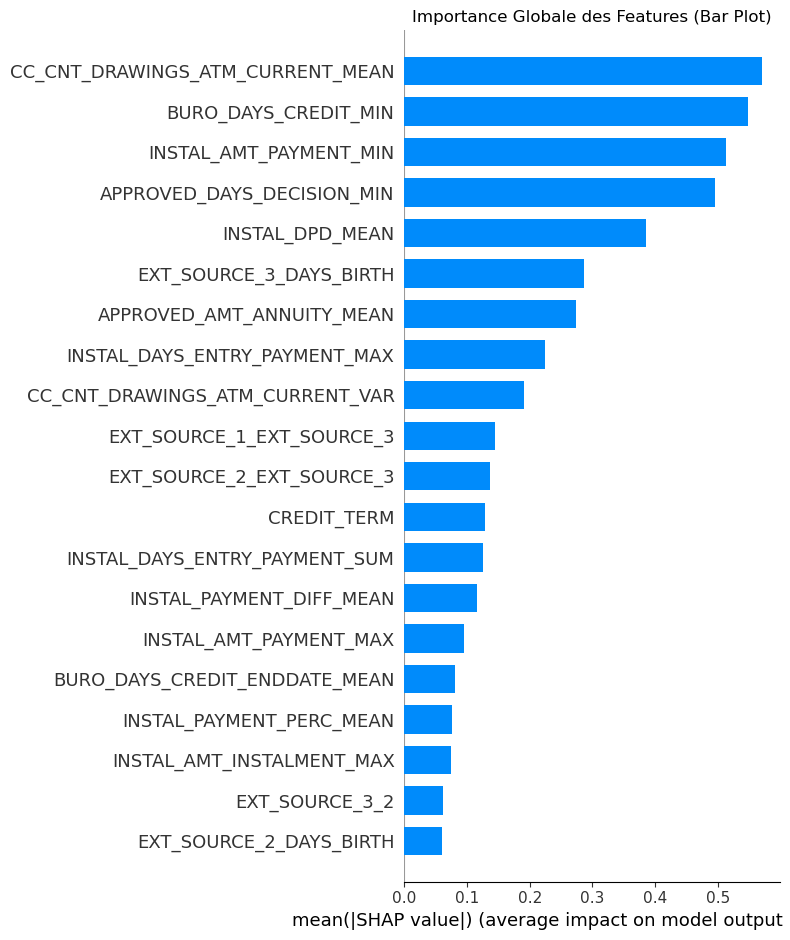

In [82]:
# Summary plot de type bar
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.title("Importance Globale des Features (Bar Plot)")
plt.tight_layout()

# Sauvegarde avec plt.gcf()
fig_bar = plt.gcf()
fig_bar.savefig("global_importance_bar.png")
plt.show()

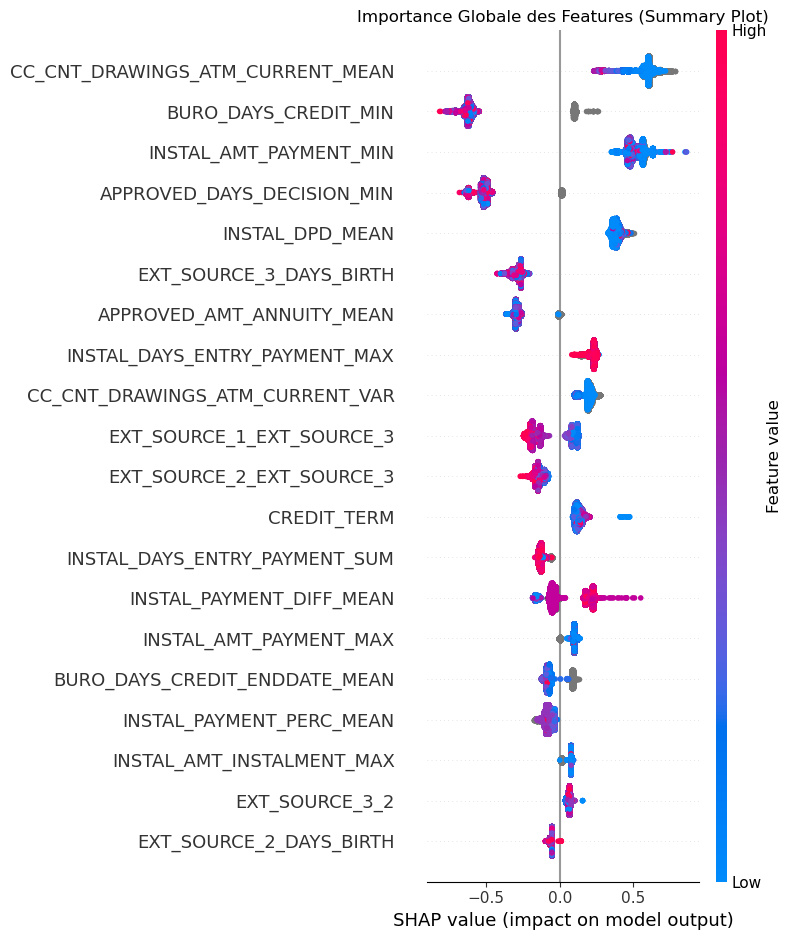

In [83]:
# Affichage du summary plot classique (scatter plot SHAP)
shap.summary_plot(shap_values, X_test, show=False)
plt.title("Importance Globale des Features (Summary Plot)")
plt.tight_layout()

# Sauvegarde avec plt.gcf()
fig_summary = plt.gcf()
fig_summary.savefig("global_importance_summary.png")
plt.show()

In [84]:
# Enregistrement des artefacts MLflow
mlflow.log_artifact("global_importance_bar.png", artifact_path="artifacts")
mlflow.log_artifact("global_importance_summary.png", artifact_path="artifacts")
mlflow.log_artifact("roc_curve.png", artifact_path="artifacts")

print("Tous les artefacts sont enregistrés correctement dans MLflow.")

Tous les artefacts sont enregistrés correctement dans MLflow.


## 7.4 Analyse locale de l'importance des variables

Afin d’analyser comment le modèle prend une décision spécifique, nous visualisons les contributions locales des variables pour quelques exemples individuels du jeu de test (ici, 10 exemples).

In [85]:
# Sélection d'un sous-échantillon de 10 lignes
sample_data = X_test.iloc[:10, :] if isinstance(X_test, pd.DataFrame) else X_test[:10, :]

# Calcul des valeurs SHAP pour l'échantillon
shap_values_sample = explainer(sample_data)

# Dossier temporaire pour stocker les graphiques
os.makedirs("shap_plots", exist_ok=True)

🔹 Waterfall plot pour l'échantillon 1 :


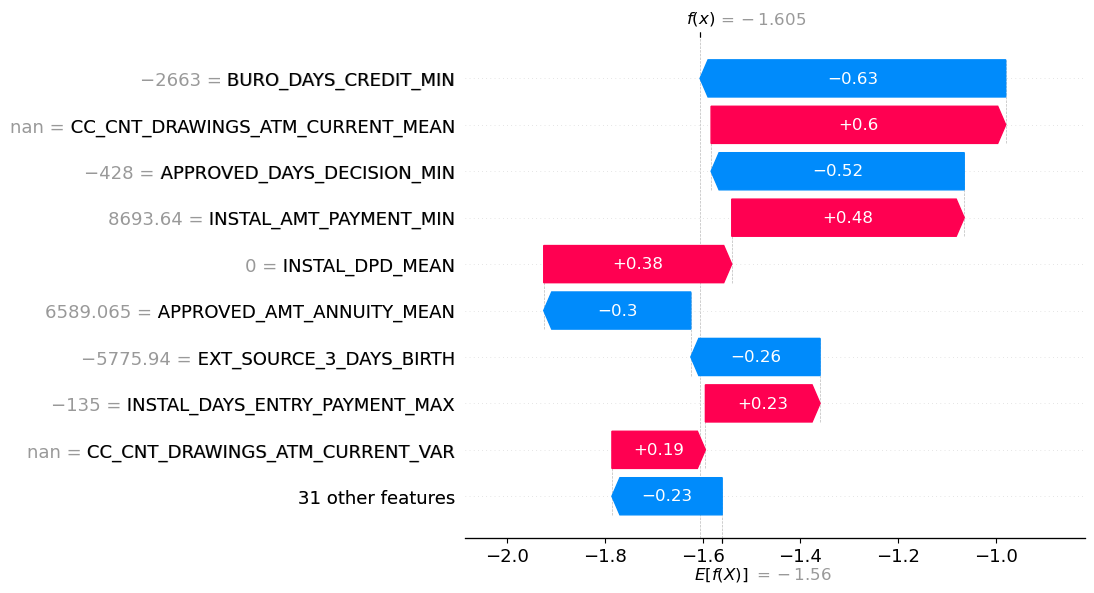

🔹 Waterfall plot pour l'échantillon 2 :


<Figure size 640x480 with 0 Axes>

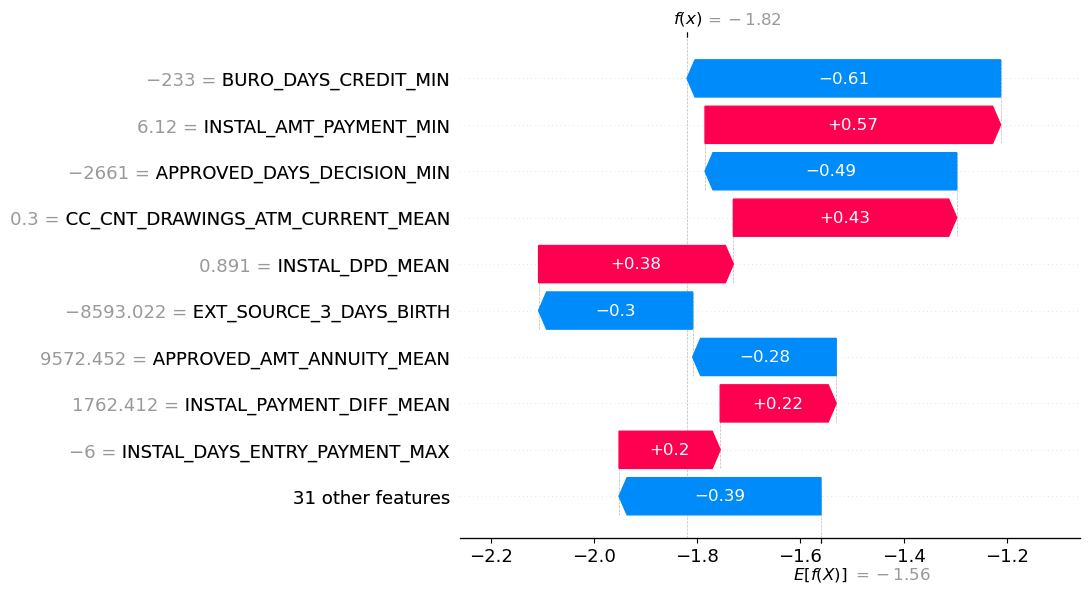

🔹 Waterfall plot pour l'échantillon 3 :


<Figure size 640x480 with 0 Axes>

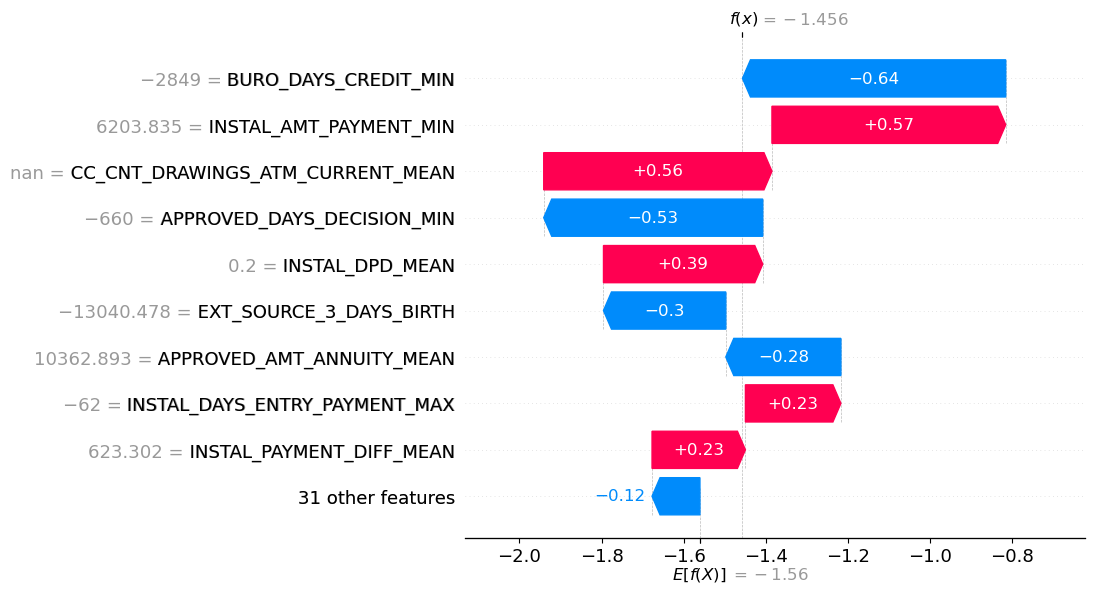

🔹 Waterfall plot pour l'échantillon 4 :


<Figure size 640x480 with 0 Axes>

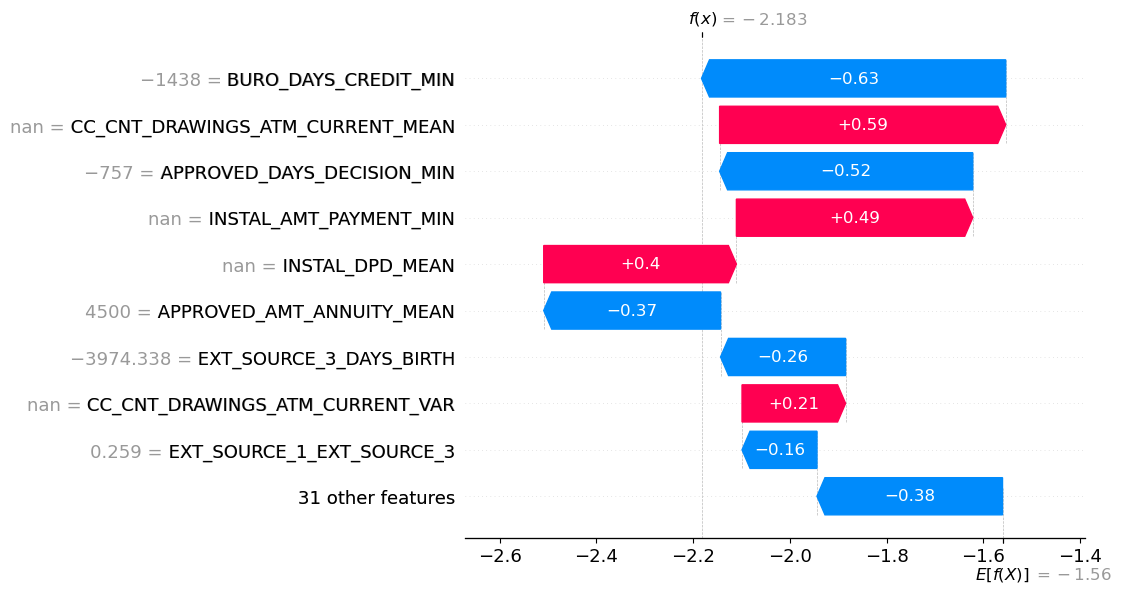

🔹 Waterfall plot pour l'échantillon 5 :


<Figure size 640x480 with 0 Axes>

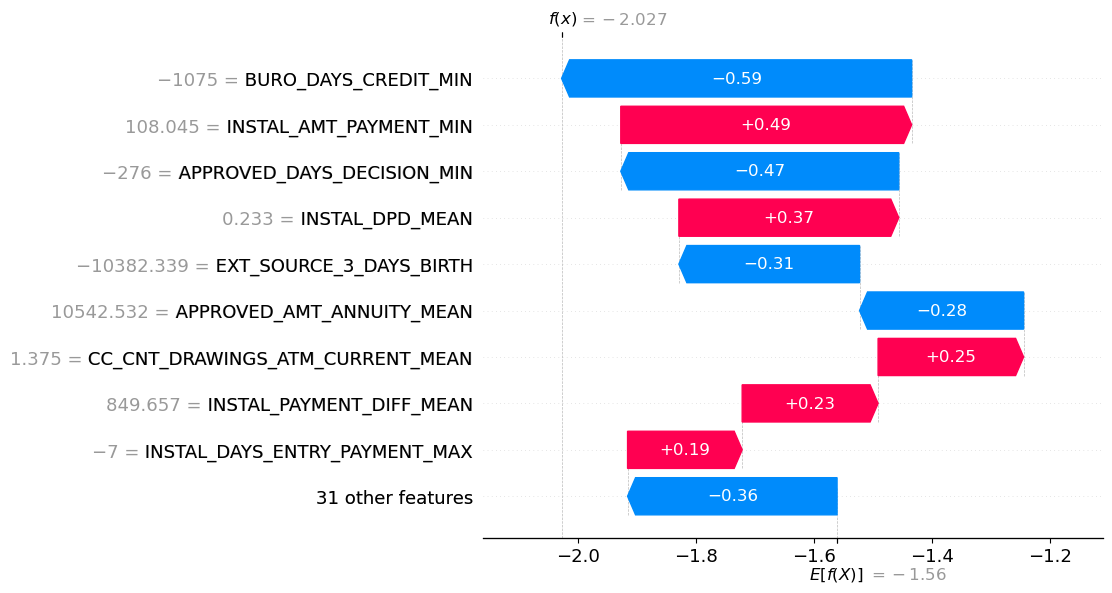

🔹 Waterfall plot pour l'échantillon 6 :


<Figure size 640x480 with 0 Axes>

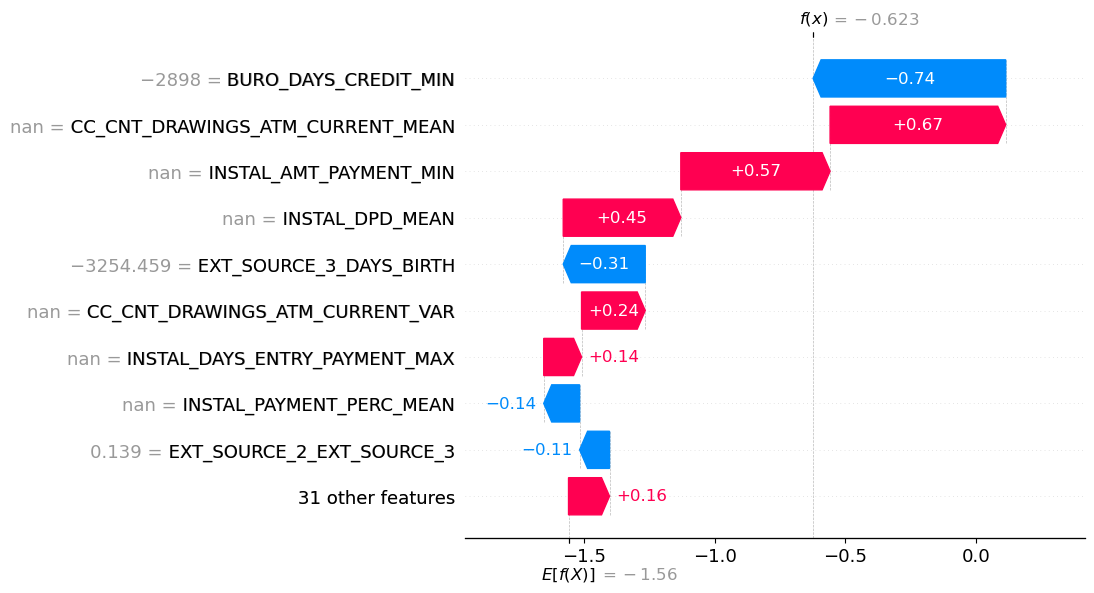

🔹 Waterfall plot pour l'échantillon 7 :


<Figure size 640x480 with 0 Axes>

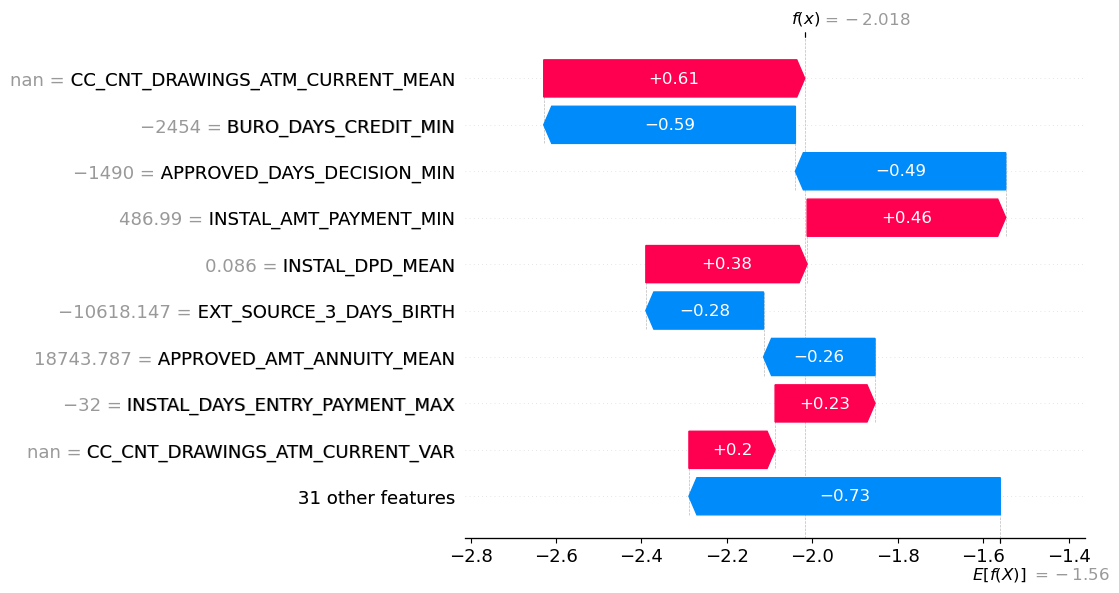

🔹 Waterfall plot pour l'échantillon 8 :


<Figure size 640x480 with 0 Axes>

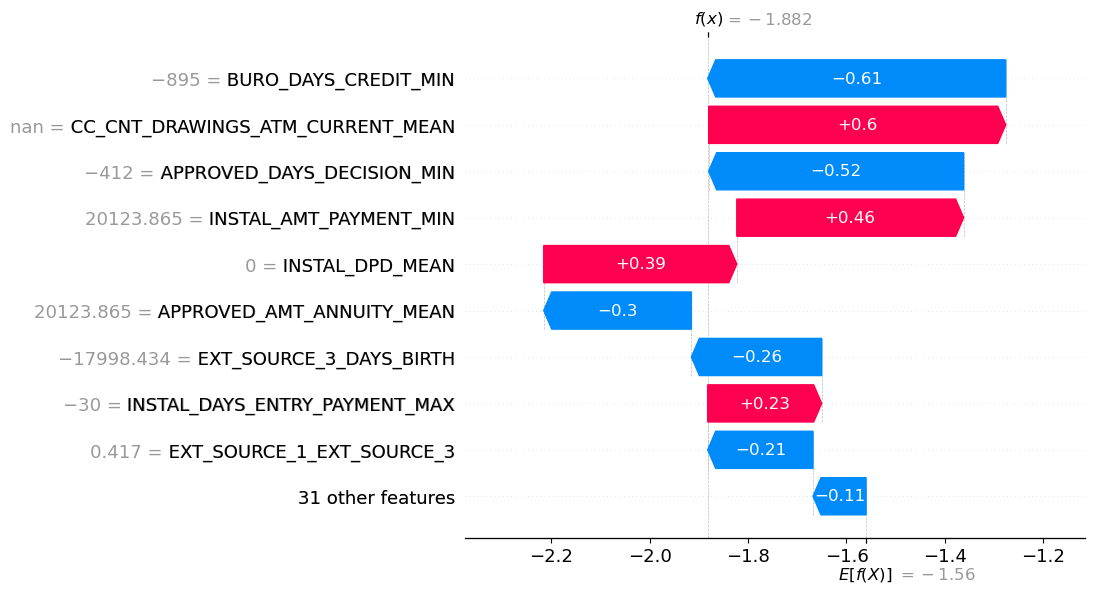

🔹 Waterfall plot pour l'échantillon 9 :


<Figure size 640x480 with 0 Axes>

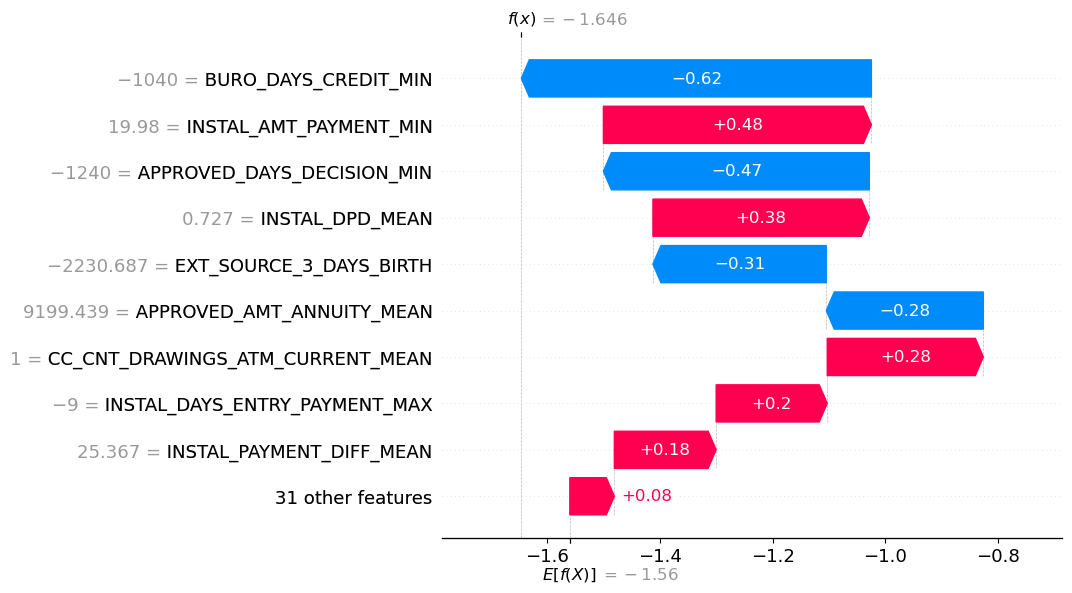

🔹 Waterfall plot pour l'échantillon 10 :


<Figure size 640x480 with 0 Axes>

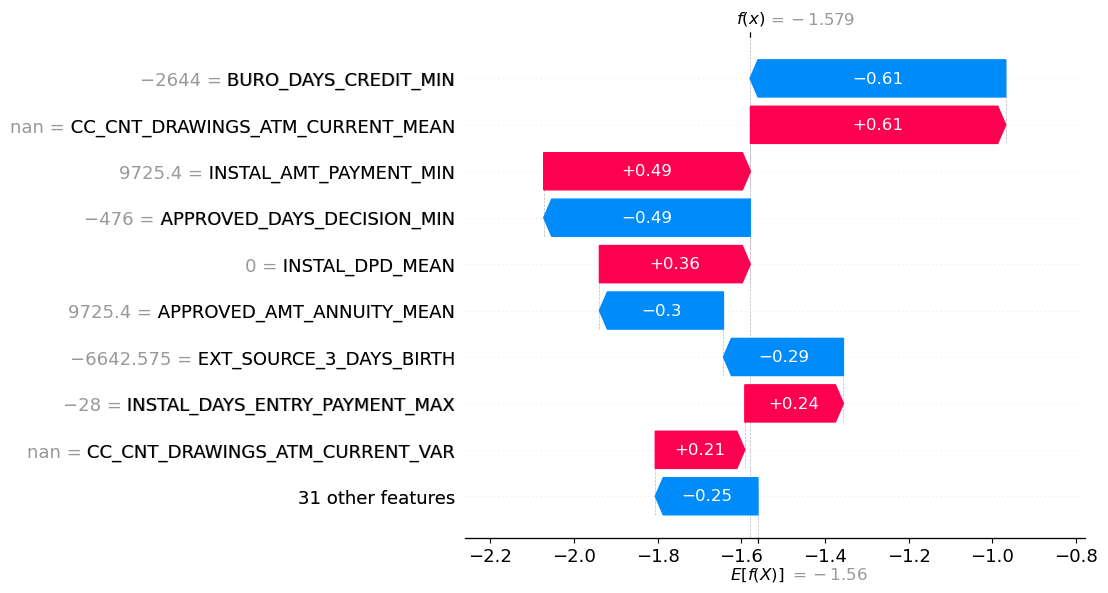

Tous les Waterfall plots ont été affichés et enregistrés dans MLflow.


<Figure size 640x480 with 0 Axes>

In [86]:
# Génération, sauvegarde et enregistrement des waterfall plots individuels dans MLflow
for i in range(len(sample_data)):
    file_path = f"shap_plots/waterfall_{i}.png"

    print(f"🔹 Waterfall plot pour l'échantillon {i+1} :")

    # Création du waterfall plot SHAP
    plt.figure()  # Nouvelle figure pour éviter les conflits
    shap.plots.waterfall(shap_values_sample[i], show=True)  

    # Sauvegarde du graphique
    plt.savefig(file_path, bbox_inches='tight', dpi=300)

    #  Enregistrement de l’image dans MLflow
    mlflow.log_artifact(file_path)

# Confirmation
print("Tous les Waterfall plots ont été affichés et enregistrés dans MLflow.")

## 7.5 Réduction du nombre de features

### Selection des features

In [87]:
# Calcul de l'importance moyenne absolue
mean_abs_shap = np.abs(shap_values).mean(axis=0)
feature_importance = pd.DataFrame({
    'feature': X_test.columns,
    'importance': mean_abs_shap
}).sort_values(by='importance', ascending=False)

In [88]:
# Selection des 20 features les plus importantes
top_20_features = feature_importance['feature'].head(20).tolist()

In [89]:
print("Top 20 features les plus importantes :")
for i, feat in enumerate(top_20_features, 1):
    print(f"{i}. {feat}")

Top 20 features les plus importantes :
1. CC_CNT_DRAWINGS_ATM_CURRENT_MEAN
2. BURO_DAYS_CREDIT_MIN
3. INSTAL_AMT_PAYMENT_MIN
4. APPROVED_DAYS_DECISION_MIN
5. INSTAL_DPD_MEAN
6. EXT_SOURCE_3_DAYS_BIRTH
7. APPROVED_AMT_ANNUITY_MEAN
8. INSTAL_DAYS_ENTRY_PAYMENT_MAX
9. CC_CNT_DRAWINGS_ATM_CURRENT_VAR
10. EXT_SOURCE_1_EXT_SOURCE_3
11. EXT_SOURCE_2_EXT_SOURCE_3
12. CREDIT_TERM
13. INSTAL_DAYS_ENTRY_PAYMENT_SUM
14. INSTAL_PAYMENT_DIFF_MEAN
15. INSTAL_AMT_PAYMENT_MAX
16. BURO_DAYS_CREDIT_ENDDATE_MEAN
17. INSTAL_PAYMENT_PERC_MEAN
18. INSTAL_AMT_INSTALMENT_MAX
19. EXT_SOURCE_3_2
20. EXT_SOURCE_2_DAYS_BIRTH


In [90]:
# Réduction de X_train et X_test
X_train_reduced = X_train[top_20_features].copy()
X_test_reduced = X_test[top_20_features].copy()

### Détection des types de colonnes parmi les 20 features

In [91]:
binary_cols_20 = [col for col in X_train_reduced.columns if set(X_train_reduced[col].dropna().unique()).issubset({0, 1})]
numeric_cols_20 = [col for col in X_train_reduced.columns if col not in binary_cols_20]

### Preprocessing adapté aux 20 features

In [92]:
preprocessor_20 = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), numeric_cols_20),
    ('bin', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent'))
    ]), binary_cols_20)
])

### Création du pipeline avec le modèle optimisé

In [93]:
if best_model_name == "LightGBM":
    model_20 = LGBMClassifier(**best_params, random_state=42, verbosity=-1)
elif best_model_name == "RandomForest":
    model_20 = RandomForestClassifier(**best_params, random_state=42)
elif best_model_name == "XGBoost":
    model_20 = XGBClassifier(**best_params, use_label_encoder=False, eval_metric="logloss", random_state=42)

pipeline_20 = ImbPipeline([
    ('preprocessor', preprocessor_20),
    ('smote', SMOTE(sampling_strategy=0.3, random_state=42)),
    ('model', model_20)
])

### Entraînement du modèle

In [94]:
pipeline_20.fit(X_train_reduced, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['CC_CNT_DRAWINGS_ATM_CURRENT_MEAN',
                                                   'BURO_DAYS_CREDIT_MIN',
                                                   'INSTAL_AMT_PAYMENT_MIN',
                                                   'APPROVED_DAYS_DECISION_MIN',
                                                   'INSTAL_DPD_MEAN',
                                                   'EXT_SOURCE_3_DAYS_BIRTH',
                                                   'APPROVED_AMT_ANNUITY_MEAN',
                                                   'IN...
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  [])])),
                ('smote', SMOTE(random_state=42, sampling_strategy=0.3)),
                ('model',
                 LGBMClassifier(colsample_bytree=0.7952362719480109,
                                learning_rate=0.04448339222627268,
                                n_estimators=290, num_leaves=13,
                                random_state=42,
                                reg_alpha=4.272661901360118e-06,
                                reg_lambda=7.390301467885012e-09,
                                subsample=0.6853774227855893, verbosity=-1))])

### Prédictions sur X_test réduit

In [95]:
y_proba_test_20 = pipeline_20.predict_proba(X_test_reduced)[:, 1]
best_threshold_20, cost_20 = find_optimal_threshold(y_test, y_proba_test_20)
y_pred_test_20 = (y_proba_test_20 >= best_threshold_20).astype(int)

### Évaluation

In [96]:
auc_20 = roc_auc_score(y_test, y_proba_test_20)
f1_20 = f1_score(y_test, y_pred_test_20)
precision_20 = precision_score(y_test, y_pred_test_20)
recall_20 = recall_score(y_test, y_pred_test_20)

### Affichage des résultats

In [104]:
print("\n Résultats modèle initial (toutes features) avant HyperOpt :")
print(f"AUC : {test_auc:.4f} | F1 : {test_f1:.4f} | Coût : {optimal_cost:.2f}")
print(f"Seuil optimal : {best_threshold:.2f}")

print("\n Résultats modèle réduit (20 features SHAP) :")
print(f"AUC : {auc_20:.4f} | F1 : {f1_20:.4f} | Coût : {cost_20:.2f}")
print(f"Seuil optimal : {best_threshold_20:.2f}")


 Résultats modèle initial (toutes features) avant HyperOpt :
AUC : 0.7280 | F1 : 0.2541 | Coût : 35035.00
Seuil optimal : 0.39

 Résultats modèle réduit (20 features SHAP) :
AUC : 0.7277 | F1 : 0.2482 | Coût : 35011.00
Seuil optimal : 0.18


## 7.6 Enregistrement du modèle réduit à 20 features

### Sauvegarde en Joblib

In [98]:
joblib.dump(pipeline_20, "best_model_20_features.joblib")
print("📦 Modèle allégé sauvegardé : best_model_20_features.joblib")

📦 Modèle allégé sauvegardé : best_model_20_features.joblib


### Enregistrement dans MLflow

In [99]:
# S'assurer qu'aucun run n'est encore actif
if mlflow.active_run():
    mlflow.end_run()

try:
    with mlflow.start_run(run_name="Model_20_Features"):
        signature_20 = infer_signature(X_test_reduced, pipeline_20.predict(X_test_reduced))
        input_example_20 = X_test_reduced.iloc[:5]

        mlflow.sklearn.log_model(
            sk_model=pipeline_20,
            artifact_path="models/model_20_features",
            input_example=input_example_20,
            signature=signature_20
        )

        # Log des métriques
        mlflow.log_metric("Test AUC", auc_20)
        mlflow.log_metric("Test F1 Score", f1_20)
        mlflow.log_metric("Test Precision", precision_20)
        mlflow.log_metric("Test Recall", recall_20)
        mlflow.log_metric("Test Business Cost", cost_20)
        mlflow.log_metric("Optimal Threshold", best_threshold_20)

        print("Modèle 20 features + métriques enregistrés dans MLflow")

except Exception as e:
    print(f"Erreur lors de l'enregistrement dans MLflow : {e}")

Modèle 20 features + métriques enregistrés dans MLflow


## 8. Lancement et consultation du tableau de bord MLflow

Pour visualiser les résultats détaillés de nos expériences et suivre précisément les performances des modèles entraînés, nous utilisons le tableau de bord MLflow (MLflow UI).
Le script suivant vérifie que MLflow est installé, démarre automatiquement l'interface utilisateur MLflow si elle n'est pas déjà en cours d'exécution, et permet d'accéder directement à l'interface via un lien local.

In [100]:
# Vérifier si MLflow est installé
try:
    subprocess.run(["mlflow", "--version"], check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True, encoding="cp1252")
except FileNotFoundError:
    print("MLflow n'est pas installé ou n'est pas accessible depuis l'environnement.")
    print("Installe-le avec : `pip install mlflow`")
    raise SystemExit

# Vérifier si un serveur MLflow tourne déjà
try:
    process = subprocess.run(["tasklist"], capture_output=True, text=True, encoding="cp1252")
    if "mlflow.exe" in process.stdout:
        print("Un serveur MLflow tourne déjà. Ouvre-le ici : http://127.0.0.1:5000")
    else:
        # Démarrer MLflow UI en arrière-plan
        mlflow_ui_process = subprocess.Popen(["mlflow", "ui", "--backend-store-uri", "file:///C:/Users/guigo/Documents/FORMATION/Alternance/Projet 7/mlruns", "--port", "5000"],
    stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True, encoding="cp1252"
)
        time.sleep(5)  # Attendre quelques secondes pour éviter les erreurs

        print("MLflow UI est en cours d'exécution.")
        display(HTML('<a href="http://127.0.0.1:5000" target="_blank">Ouvrir MLflow UI</a>'))

except Exception as e:
    print(f"Erreur lors du lancement de MLflow UI : {e}")

MLflow n'est pas installé ou n'est pas accessible depuis l'environnement.
Installe-le avec : `pip install mlflow`


SystemExit: 

In [ ]:
# Dans le terminal pour lancer l'API
#mlflow ui --backend-store-uri "file:///C:/Users/guigo/Documents/FORMATION/Alternance/Projet 7/mlruns"